In [1]:
import matplotlib.pyplot as plt
import hipercam as hcam
import numpy as np
from astropy import time, coordinates as coord, units as u
from astropy.coordinates import EarthLocation, AltAz
from astropy.timeseries import TimeSeries
from astropy.time import TimeDelta
from astropy.time import Time

In [2]:
#funcs
def y_to_flux(y,ye,te):
    flux = y/(te*86400)
    flux_err = ye/(te*86400)
    flux_std_err = np.mean(flux_err) / np.sqrt(len(flux_err))
    return flux , flux_err , flux_std_err


def flux_to_mag(flux, error):
    mag = -1 * 2.5*np.log10(flux)
    mag_err = (2.5 / np.log(10)) * (error/flux)
    return mag, mag_err


def mag_to_flux(mag):
    flux = 10**(-0.4 * mag)
    return flux


#def magAB_to_flux(mag, ):
  #  ABflux = 10**(-0.4 * (mag-8.90))
    #ABflux_err = mag_err * (np.log(10) / 2.5) * ABflux
   # return ABflux
def magAB_to_flux(mag):
    ABflux = 10**(-0.4 * (mag-8.90))
    #ABflux_err = mag_err * (np.log(10) / 2.5) * ABflux
    return ABflux

def flux_to_ABmag(flux):
    ABmag = -2.5 * np.log10(flux) + 8.90
    #ABmagErr = (flux_err/flux) * (2.5 / np.log(10))
    return ABmag


def airmass(target_coords,times):
    """
    Returns target airmass given an array of astropy times and the target position.
    """

    frame = AltAz(obstime=times, location=tel_location)
    altazs = target_coords.transform_to(frame)
    airmasses = altazs.secz
    return airmasses
def calculate_phase(bmjd,reference_epoch,period):
    
    phase = ((bmjd - reference_epoch) / period) % 1
    # Shift phases near 1 to negative values
    return np.where(phase < 0.90, phase, phase - 1)






reference_epoch =55641.43601610334
period = 0.24613528148209396


In [3]:
scipath =r'/home/pha19jgb/Science_Runs/2024_04_16/FluxCal/SG/SGReduce.log'
#scipath =r'/home/pha19jgb/Science_Runs/2024_04_16/FluxCal/SG/run0021.log'


sci_date = scipath.split('/')[-2]


scilog = hcam.hlog.Hlog.rascii(scipath)
tel_location = EarthLocation.of_site('Roque de los Muchachos, La Palma')
obj = coord.SkyCoord("17:17:17.0","+67:57:04",unit=(u.hourangle, u.deg), frame='icrs')

In [4]:
#Extracting the infomation from the log as a time series, ("CCD","Aperture")

sci_u = scilog.tseries("1","1")
sci_g = scilog.tseries("2","1")
sci_r = scilog.tseries("3","1")
sci_i = scilog.tseries("4","1")
sci_z = scilog.tseries("5","1")

In [5]:
#Extracing the same infomation but for the COMPO star

comp_u = scilog.tseries("1","2")
#comp_u = scilog.tseries('1','3') + scilog.tseries('1','4')
ind_u1 = scilog.tseries("1","3")
ind_u2 = scilog.tseries("1","4")

comp_g = scilog.tseries("2","3") + scilog.tseries('2','4') 
#comp_g = scilog.tseries("1","2")
ind_g1 = scilog.tseries("2","3")
ind_g2 = scilog.tseries("2","4")

comp_r = scilog.tseries("3","3") + scilog.tseries('3','4')
#comp_r = scilog.tseries("1","2")
ind_r1 = scilog.tseries("3","3")
ind_r2 = scilog.tseries("3","4")

comp_i = scilog.tseries("4","3") + scilog.tseries('4','4')
#comp_i = scilog.tseries("1","2")
ind_i1 = scilog.tseries("4","3")
ind_i2 = scilog.tseries("4","4")

comp_z = scilog.tseries("5","3") +  scilog.tseries('5','4')
#comp_z = scilog.tseries("1","2")
ind_z1 = scilog.tseries("5","3")
ind_z2 = scilog.tseries("5","4")


In [6]:
#Reading the middle time of exposures from pings to a GPS satellite in MJD+UTC, needs to have barycentric corrections performed as the earth moves 

obstime_u_t = time.Time(sci_u.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_g_t = time.Time(sci_g.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_r_t = time.Time(sci_r.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_i_t = time.Time(sci_i.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_z_t = time.Time(sci_z.t, format = 'mjd' , scale = 'utc', location = tel_location)

#Now with COMPO

obstime_u_c = time.Time(comp_u.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_g_c = time.Time(comp_g.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_r_c = time.Time(comp_r.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_i_c = time.Time(comp_i.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_z_c = time.Time(comp_z.t, format = 'mjd' , scale = 'utc', location = tel_location)

In [7]:
#Barycentric (Solar System (double check) COM) correction built into astropy.Time

barydelta_u_t = obstime_u_t.light_travel_time(obj)
barydelta_g_t = obstime_g_t.light_travel_time(obj)
barydelta_r_t = obstime_r_t.light_travel_time(obj) 
barydelta_i_t = obstime_i_t.light_travel_time(obj) 
barydelta_z_t = obstime_z_t.light_travel_time(obj) 

#now with COMPO

barydelta_u_c = obstime_u_c.light_travel_time(obj)
barydelta_g_c = obstime_g_c.light_travel_time(obj)
barydelta_r_c = obstime_r_c.light_travel_time(obj) 
barydelta_i_c = obstime_i_c.light_travel_time(obj) 
barydelta_z_c = obstime_z_c.light_travel_time(obj) 

#now te?


In [8]:
#Applying Barycentric correction

baryobs_u_t = (obstime_u_t.tdb + barydelta_u_t) 
baryobs_g_t = (obstime_g_t.tdb + barydelta_g_t) 
baryobs_r_t = (obstime_r_t.tdb + barydelta_r_t) 
baryobs_i_t = (obstime_i_t.tdb + barydelta_i_t) 
baryobs_z_t = (obstime_z_t.tdb + barydelta_z_t) 
#now with COMPO

baryobs_u_c = (obstime_u_c.tdb + barydelta_u_c)
baryobs_g_c = (obstime_g_c.tdb + barydelta_g_c)
baryobs_r_c = (obstime_r_c.tdb + barydelta_r_c)
baryobs_i_c = (obstime_i_c.tdb + barydelta_i_c)
baryobs_z_c = (obstime_z_c.tdb + barydelta_z_c)

In [9]:
ratio_u = np.array(sci_u.y / comp_u.y)
ratio_g = np.array(sci_g.y / comp_g.y)
ratio_r = np.array(sci_r.y / comp_r.y)
ratio_i = np.array(sci_i.y / comp_i.y)
ratio_z = np.array(sci_z.y / comp_z.y)

In [10]:
#now to transfer into magnitudes for the science target, #assuming .y is flux

#Sci Targ
sci_flux_u , sci_flux_u_err, sci_flux_u_std_err  = y_to_flux(sci_u.y , sci_u.ye, sci_u.te)
sci_flux_g , sci_flux_g_err, sci_flux_g_std_err  = y_to_flux(sci_g.y , sci_g.ye, sci_g.te)
sci_flux_r , sci_flux_r_err, sci_flux_r_std_err  = y_to_flux(sci_r.y , sci_r.ye, sci_r.te)
sci_flux_i , sci_flux_i_err, sci_flux_i_std_err  = y_to_flux(sci_i.y , sci_i.ye, sci_i.te)
sci_flux_z , sci_flux_z_err, sci_flux_z_std_err  = y_to_flux(sci_z.y , sci_z.ye, sci_z.te)

sci_mag_u , sci_mag_u_err = flux_to_mag(sci_flux_u,sci_flux_u_err)
sci_mag_g , sci_mag_g_err = flux_to_mag(sci_flux_g,sci_flux_g_err)
sci_mag_r , sci_mag_r_err = flux_to_mag(sci_flux_r,sci_flux_r_err)
sci_mag_i , sci_mag_i_err = flux_to_mag(sci_flux_i,sci_flux_i_err)
sci_mag_z , sci_mag_z_err = flux_to_mag(sci_flux_z,sci_flux_z_err)

#Sci Comp
comp_flux_u , comp_flux_u_err, comp_flux_u_std_err = y_to_flux(comp_u.y,comp_u.ye,comp_u.te)
comp_flux_g , comp_flux_g_err, comp_flux_g_std_err = y_to_flux(comp_g.y,comp_g.ye,comp_g.te)
comp_flux_r , comp_flux_r_err, comp_flux_r_std_err = y_to_flux(comp_r.y,comp_r.ye,comp_r.te)
comp_flux_i , comp_flux_i_err, comp_flux_i_std_err = y_to_flux(comp_i.y,comp_i.ye,comp_i.te)
comp_flux_z , comp_flux_z_err, comp_flux_z_std_err = y_to_flux(comp_z.y,comp_z.ye,comp_z.te)

comp_mag_u , comp_mag_u_err = flux_to_mag(comp_flux_u,comp_flux_u_err)
comp_mag_g , comp_mag_g_err = flux_to_mag(comp_flux_g,comp_flux_g_err)
comp_mag_r , comp_mag_r_err = flux_to_mag(comp_flux_r,comp_flux_r_err)
comp_mag_i , comp_mag_i_err = flux_to_mag(comp_flux_i,comp_flux_i_err)
comp_mag_z , comp_mag_z_err = flux_to_mag(comp_flux_z,comp_flux_z_err)

#also need Sci Airmasses
sci_airm_u = airmass(obj,obstime_u_t)
sci_airm_g = airmass(obj,obstime_g_t)
sci_airm_r = airmass(obj,obstime_r_t)
sci_airm_i = airmass(obj,obstime_i_t)
sci_airm_z = airmass(obj,obstime_z_t)


comp_airm_u = airmass(obj,obstime_u_c)
comp_airm_g = airmass(obj,obstime_g_c)
comp_airm_r = airmass(obj,obstime_r_c)
comp_airm_i = airmass(obj,obstime_i_c)
comp_airm_z = airmass(obj,obstime_z_c)

In [11]:
#trying to get the specific values for the flux calibrations
#g bands first

ind1_flux_u , ind1_flux_u_err , ind1_flux_u_std = y_to_flux(ind_u1.y, ind_u1.ye, ind_u1.te) # counts to flux
ind2_flux_u , ind2_flux_u_err , ind2_flux_u_std = y_to_flux(ind_u2.y,ind_u2.ye,ind_u2.te)

ind1_mag_u , ind1_mag_u_err = flux_to_mag(ind1_flux_u,ind1_flux_u_err) # flux to mag
ind2_mag_u , ind2_mag_u_err = flux_to_mag(ind2_flux_u,ind2_flux_u_err)

ind1_flux_g , ind1_flux_g_err , ind1_flux_g_std = y_to_flux(ind_g1.y, ind_g1.ye, ind_g1.te) # counts to flux
ind2_flux_g , ind2_flux_g_err , ind2_flux_g_std = y_to_flux(ind_g2.y,ind_g2.ye,ind_g2.te)



ind1_mag_g , ind1_mag_g_err = flux_to_mag(ind1_flux_g,ind1_flux_g_err) # flux to mag
ind2_mag_g , ind2_mag_g_err = flux_to_mag(ind2_flux_g,ind2_flux_g_err)

#r bands
ind1_flux_r , ind1_flux_r_err , ind1_flux_r_err = y_to_flux(ind_r1.y,ind_r1.ye,ind_r1.te) # counts to flux
ind2_flux_r , ind2_flux_r_err , ind2_flux_r_err = y_to_flux(ind_r2.y,ind_r2.ye,ind_r2.te)

ind1_mag_r , ind1_mag_r_err = flux_to_mag(ind1_flux_r,ind1_flux_r_err) # flux to mag
ind2_mag_r , ind2_mag_r_err = flux_to_mag(ind2_flux_r,ind2_flux_r_err)

#i
ind1_flux_i , ind1_flux_i_err , ind1_flux_i_err = y_to_flux(ind_i1.y,ind_i1.ye,ind_i1.te)# counts to flux
ind2_flux_i , ind2_flux_i_err , ind2_flux_i_err = y_to_flux(ind_i2.y,ind_i2.ye,ind_i2.te)

ind1_mag_i , ind1_mag_i_err = flux_to_mag(ind1_flux_i,ind1_flux_i_err) # flux to mag
ind2_mag_i , ind2_mag_i_err = flux_to_mag(ind2_flux_i,ind2_flux_i_err)

#z
ind1_flux_z , ind1_flux_z_err , ind1_flux_z_err = y_to_flux(ind_z1.y,ind_z1.ye,ind_z1.te)# counts to flux
ind2_flux_z , ind2_flux_z_err , ind2_flux_z_err = y_to_flux(ind_z2.y,ind_z2.ye,ind_z2.te)

ind1_mag_z , ind1_mag_z_err = flux_to_mag(ind1_flux_z,ind1_flux_z_err) # flux to mag
ind2_mag_z , ind2_mag_z_err = flux_to_mag(ind2_flux_z,ind2_flux_z_err)

#testing airmasses:
obstime_ind1_u = time.Time(ind_u1.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind1u = obstime_ind1_u.light_travel_time(obj)
baryobs_ind1u = (obstime_ind1_u.tdb + barydelta_ind1u).value
ind1_airm_u = airmass(obj,obstime_ind1_u)

obstime_ind2_u = time.Time(ind_u2.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind2u = obstime_ind2_u.light_travel_time(obj)
baryobs_ind2u = (obstime_ind2_u.tdb + barydelta_ind1u).value
ind2_airm_u = airmass(obj,obstime_ind2_u)



obstime_ind1_g = time.Time(ind_g1.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind1g = obstime_ind1_g.light_travel_time(obj)
baryobs_ind1g = (obstime_ind1_g.tdb + barydelta_ind1g).value
ind1_airm_g = airmass(obj,obstime_ind1_g)

obstime_ind2_g = time.Time(ind_g2.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind2g = obstime_ind2_g.light_travel_time(obj)
baryobs_ind2g = (obstime_ind2_g.tdb + barydelta_ind1g).value
ind2_airm_g = airmass(obj,obstime_ind2_g)

obstime_ind1_r = time.Time(ind_r1.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind1r = obstime_ind1_r.light_travel_time(obj)
baryobs_ind1r = (obstime_ind1_r.tdb + barydelta_ind1r).value
ind1_airm_r = airmass(obj,obstime_ind1_r)

obstime_ind2_r = time.Time(ind_r2.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind2r = obstime_ind2_r.light_travel_time(obj)
baryobs_ind2r = (obstime_ind2_r.tdb + barydelta_ind1r).value
ind2_airm_r = airmass(obj,obstime_ind2_r)

obstime_ind1_i = time.Time(ind_i1.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind1i = obstime_ind1_i.light_travel_time(obj)
baryobs_ind1i = (obstime_ind1_i.tdb + barydelta_ind1i).value
ind1_airm_i = airmass(obj,obstime_ind1_i)

obstime_ind2_i = time.Time(ind_i2.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind2i = obstime_ind2_i.light_travel_time(obj)
baryobs_ind2i = (obstime_ind2_i.tdb + barydelta_ind1i).value
ind2_airm_i = airmass(obj,obstime_ind2_i)

obstime_ind1_z = time.Time(ind_z1.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind1z = obstime_ind1_z.light_travel_time(obj)
baryobs_ind1z = (obstime_ind1_z.tdb + barydelta_ind1z).value
ind1_airm_z = airmass(obj,obstime_ind1_z)

obstime_ind2_z = time.Time(ind_z2.t, format = 'mjd' , scale = 'utc', location = tel_location)
barydelta_ind2z = obstime_ind2_z.light_travel_time(obj)
baryobs_ind2z = (obstime_ind2_z.tdb + barydelta_ind1z).value
ind2_airm_z = airmass(obj,obstime_ind2_z)

In [12]:
extpath =r'/home/pha19jgb/Science_Runs/2024_04_16/FluxCal/13.11/airm_red_17_02.log'
ext_date = extpath.split('/')[-2]



extlog = hcam.hlog.Hlog.rascii(extpath)
tel_location = EarthLocation.of_site('Roque de los Muchachos, La Palma')
ext = coord.SkyCoord("16:11:30.0","+63:08:29",unit=(u.hourangle, u.deg), frame='icrs')


In [13]:
airm_u = extlog.tseries("1","3")
airm_g = extlog.tseries("2","3")
airm_r = extlog.tseries("3","3")
airm_i = extlog.tseries("4","3")
airm_z = extlog.tseries("5","3")

obstime_u_airm = time.Time(airm_u.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_g_airm = time.Time(airm_g.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_r_airm = time.Time(airm_r.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_i_airm = time.Time(airm_i.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_z_airm = time.Time(airm_z.t, format = 'mjd' , scale = 'utc', location = tel_location)

barydelta_u_airm = obstime_u_airm.light_travel_time(ext)
barydelta_g_airm = obstime_g_airm.light_travel_time(ext)
barydelta_r_airm = obstime_r_airm.light_travel_time(ext) 
barydelta_i_airm = obstime_i_airm.light_travel_time(ext) 
barydelta_z_airm = obstime_z_airm.light_travel_time(ext)

baryobs_u_airm = (obstime_u_airm.tdb + barydelta_u_airm).value
baryobs_g_airm = (obstime_g_airm.tdb + barydelta_g_airm).value
baryobs_r_airm = (obstime_r_airm.tdb + barydelta_r_airm).value
baryobs_i_airm = (obstime_i_airm.tdb + barydelta_i_airm).value
baryobs_z_airm = (obstime_z_airm.tdb + barydelta_z_airm).value

airm_flux_u , airm_flux_u_err, airm_flux_u_std_err  = y_to_flux(airm_u.y , airm_u.ye, airm_u.te)
airm_flux_g , airm_flux_g_err, airm_flux_g_std_err  = y_to_flux(airm_g.y , airm_g.ye, airm_g.te)
airm_flux_r , airm_flux_r_err, airm_flux_r_std_err  = y_to_flux(airm_r.y , airm_r.ye, airm_r.te)
airm_flux_i , airm_flux_i_err, airm_flux_i_std_err  = y_to_flux(airm_i.y , airm_i.ye, airm_i.te)
airm_flux_z , airm_flux_z_err, airm_flux_z_std_err  = y_to_flux(airm_z.y , airm_z.ye, airm_z.te)

airm_mag_u , airm_mag_u_err = flux_to_mag(airm_flux_u,airm_flux_u_err)
airm_mag_g , airm_mag_g_err = flux_to_mag(airm_flux_g,airm_flux_g_err)
airm_mag_r , airm_mag_r_err = flux_to_mag(airm_flux_r,airm_flux_r_err)
airm_mag_i , airm_mag_i_err = flux_to_mag(airm_flux_i,airm_flux_i_err)
airm_mag_z , airm_mag_z_err = flux_to_mag(airm_flux_z,airm_flux_z_err)

airm_am_u = airmass(ext,obstime_u_airm)
airm_am_g = airmass(ext,obstime_g_airm)
airm_am_r = airmass(ext,obstime_r_airm)
airm_am_i = airmass(ext,obstime_i_airm)
airm_am_z = airmass(ext,obstime_z_airm)




y = 0.63x + -9.30
y = 0.20x + -11.57
y = 0.16x + -11.63
y = 0.18x + -11.49
y = 0.16x + -11.13


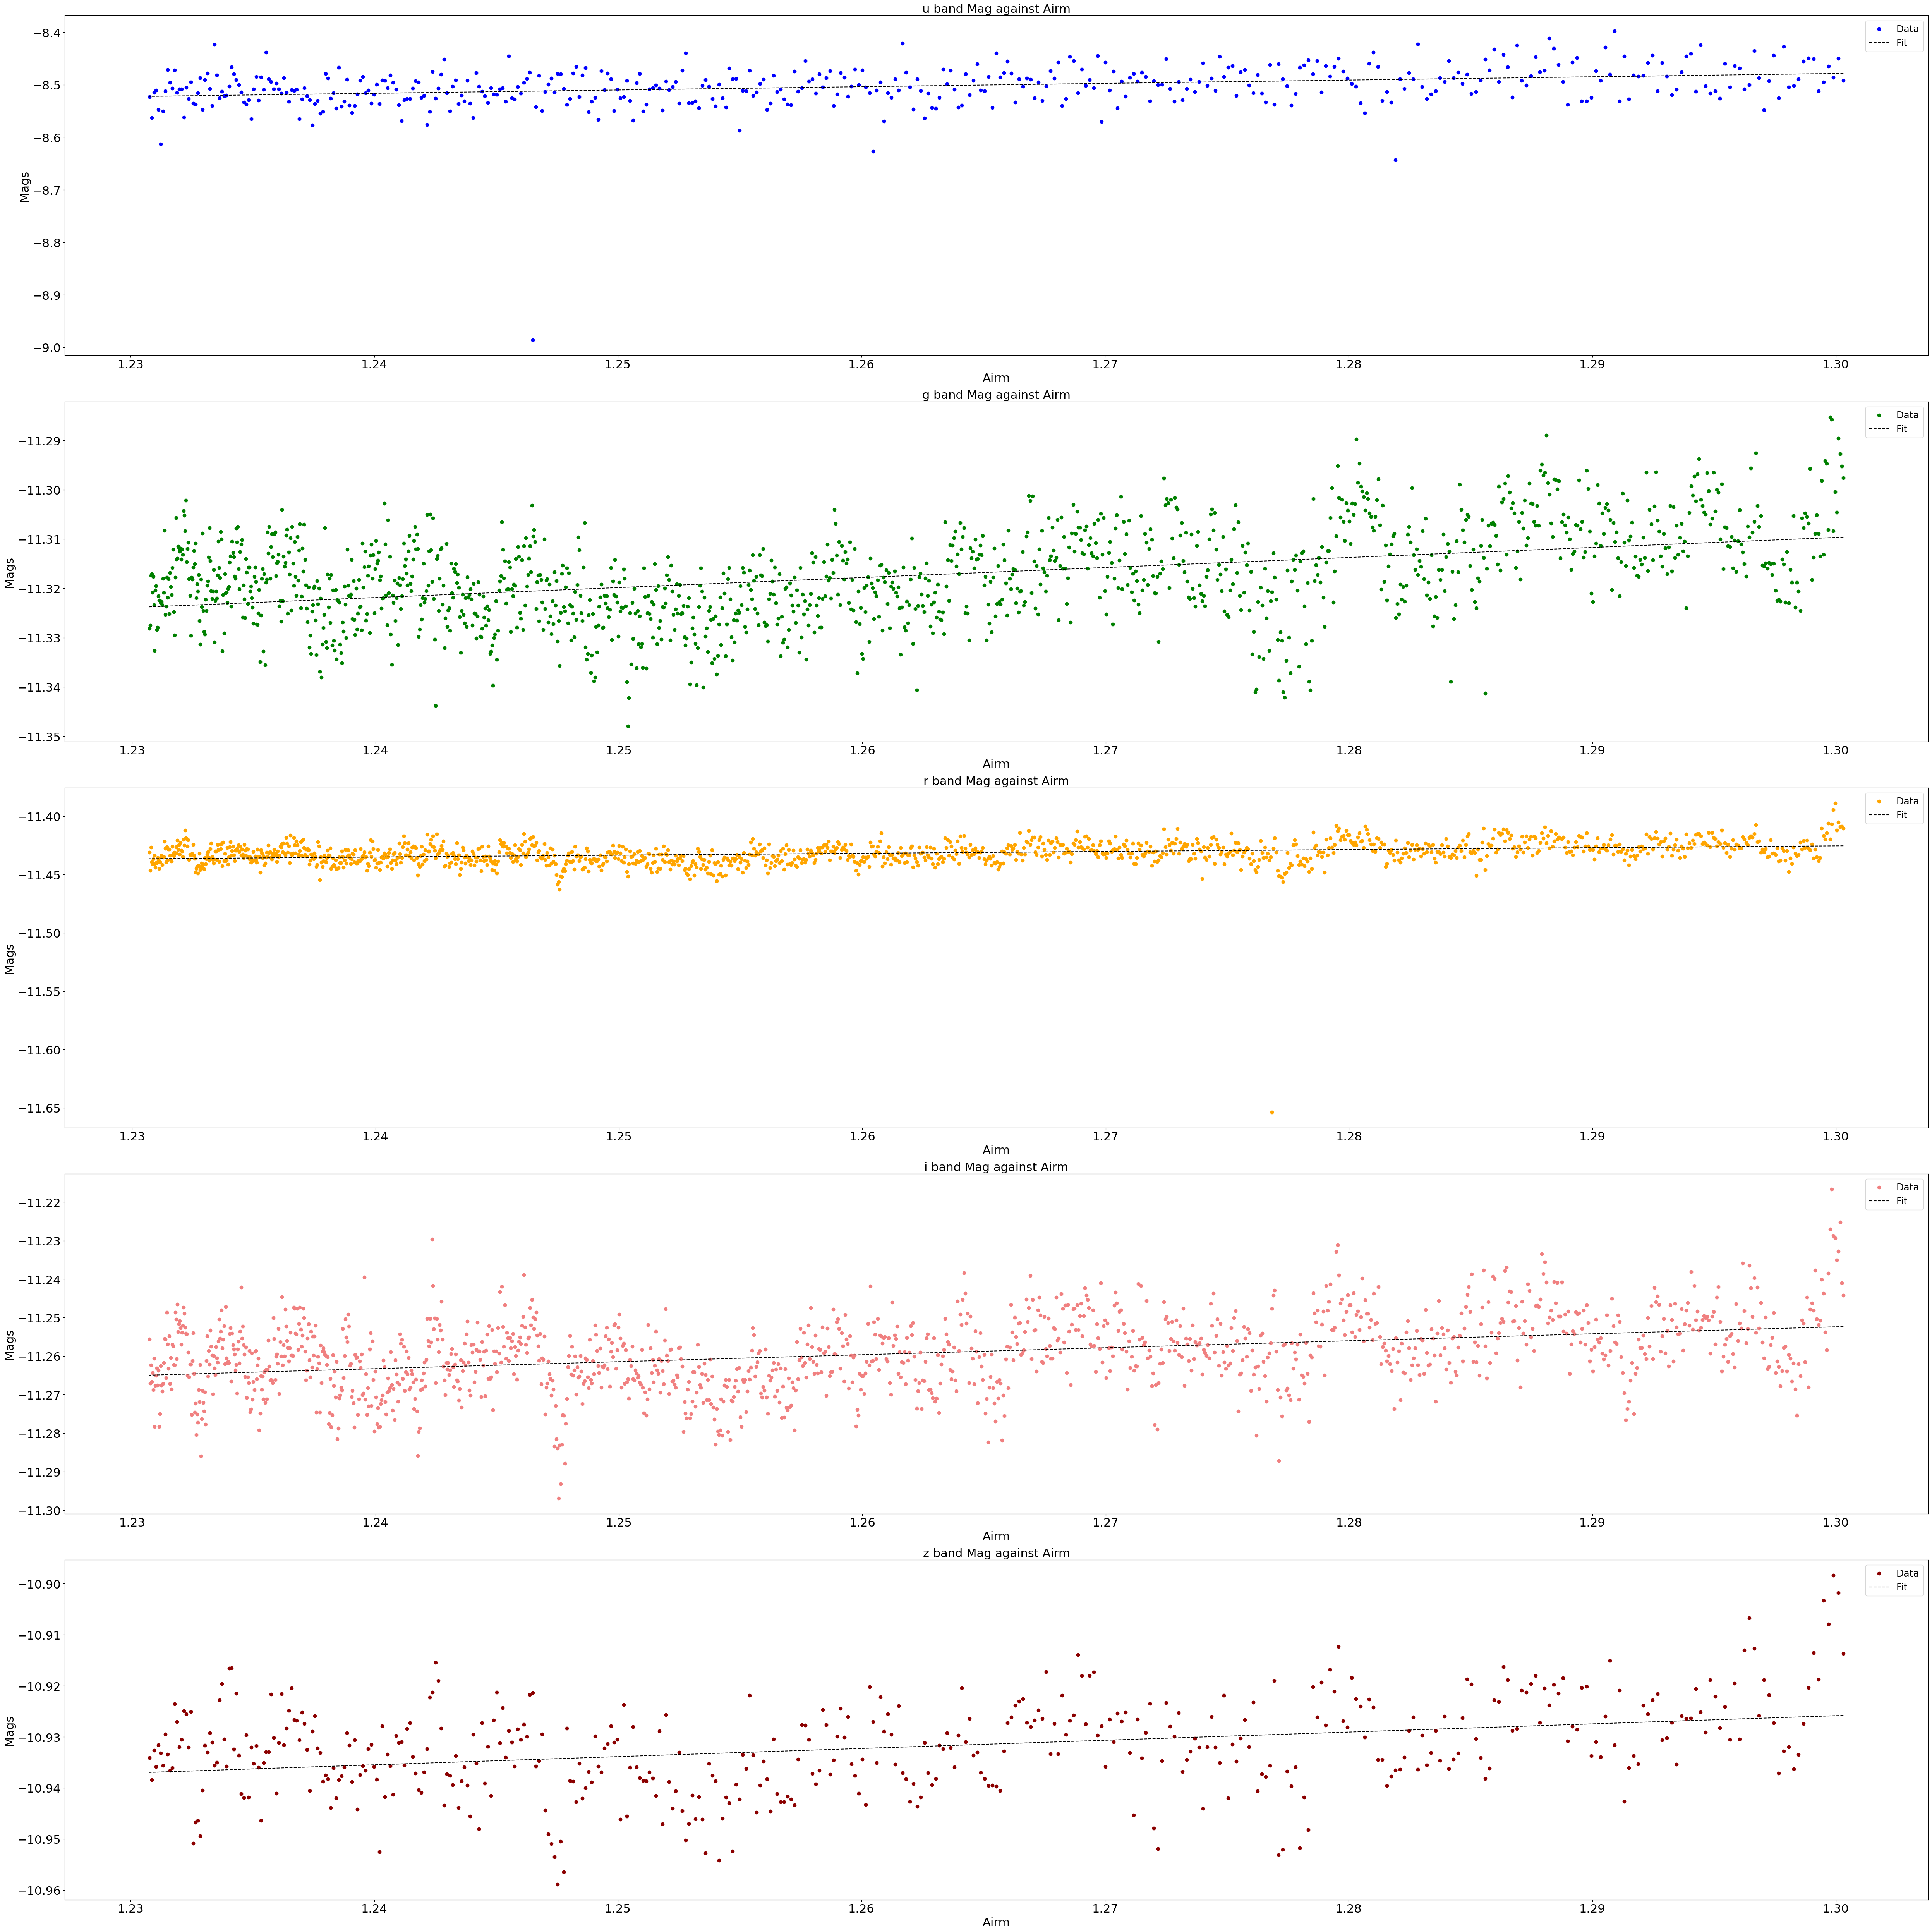

In [14]:
bands = ['u', 'g', 'r', 'i', 'z']
mags = [airm_mag_u,airm_mag_g,airm_mag_r,airm_mag_i,airm_mag_z]
airm = [airm_am_u,airm_am_g,airm_am_r,airm_am_i,airm_am_z]
colours = ['b', 'g', 'orange', 'lightcoral', 'darkred']
kx = []

fig, axs = plt.subplots(nrows=5, figsize=(50,50))  # Adjust figsize as needed


for i, (band, mag, air, colour) in enumerate(zip(bands, mags, airm, colours)):
    # Plot the original data
    axs[i].scatter(air, mag, color=colour, label='Data')

    # Fit a straight line
    coefficients = np.polyfit(air, mag, 1) 
    poly = np.poly1d(coefficients)
    fitted_line = poly(air)
    kx.append(coefficients[0])
    # Plot the fitted line
    axs[i].plot(air, fitted_line, color='black', linestyle='--', label='Fit')

    # Set title and labels
    axs[i].set_title(f"{band.lower()} band Mag against Airm", fontsize=22)
    axs[i].set_xlabel("Airm", fontsize=22)
    axs[i].set_ylabel('Mags', fontsize=22)
    axs[i].tick_params(axis='both', which='major', labelsize=22)
    axs[i].tick_params(axis='both', which='minor', labelsize=22)

    # Add legend
    axs[i].legend(fontsize=18)
    m, c = coefficients
    print(f'y = {m:.2f}x + {c:.2f}')
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [15]:

stdpath =r'/home/pha19jgb/Science_Runs/2024_04_16/FluxCal/std_11_02.log'
std_date = stdpath.split('/')[-2]

stdlog = hcam.hlog.Hlog.rascii(stdpath)
tel_location = EarthLocation.of_site('Roque de los Muchachos, La Palma')
std = coord.SkyCoord("10:39:40.0","+43:05:57",unit=(u.hourangle, u.deg), frame='icrs')

In [16]:
std_u = stdlog.tseries("1","1")
std_g = stdlog.tseries("2","1")
std_r = stdlog.tseries("3","1")
std_i = stdlog.tseries("4","1")
std_z = stdlog.tseries("5","1")

obstime_u_std = time.Time(std_u.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_g_std = time.Time(std_g.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_r_std = time.Time(std_r.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_i_std = time.Time(std_i.t, format = 'mjd' , scale = 'utc', location = tel_location)
obstime_z_std = time.Time(std_z.t, format = 'mjd' , scale = 'utc', location = tel_location)

barydelta_u_std = obstime_u_std.light_travel_time(std)
barydelta_g_std = obstime_g_std.light_travel_time(std)
barydelta_r_std = obstime_r_std.light_travel_time(std) 
barydelta_i_std = obstime_i_std.light_travel_time(std) 
barydelta_z_std = obstime_z_std.light_travel_time(std)

baryobs_u_std = (obstime_u_std.tdb + barydelta_u_std).value
baryobs_g_std = (obstime_g_std.tdb + barydelta_g_std).value
baryobs_r_std = (obstime_r_std.tdb + barydelta_r_std).value
baryobs_i_std = (obstime_i_std.tdb + barydelta_i_std).value
baryobs_z_std = (obstime_z_std.tdb + barydelta_z_std).value

std_flux_u , std_flux_u_err, std_flux_u_std_err  = y_to_flux(std_u.y , std_u.ye, std_u.te)
std_flux_g , std_flux_g_err, std_flux_g_std_err  = y_to_flux(std_g.y , std_g.ye, std_g.te)
std_flux_r , std_flux_r_err, std_flux_r_std_err  = y_to_flux(std_r.y , std_r.ye, std_r.te)
std_flux_i , std_flux_i_err, std_flux_i_std_err  = y_to_flux(std_i.y , std_i.ye, std_i.te)
std_flux_z , std_flux_z_err, std_flux_z_std_err  = y_to_flux(std_z.y , std_z.ye, std_z.te)

std_mag_u , std_mag_u_err = flux_to_mag(std_flux_u,std_flux_u_err)
std_mag_g , std_mag_g_err = flux_to_mag(std_flux_g,std_flux_g_err)
std_mag_r , std_mag_r_err = flux_to_mag(std_flux_r,std_flux_r_err)
std_mag_i , std_mag_i_err = flux_to_mag(std_flux_i,std_flux_i_err)
std_mag_z , std_mag_z_err = flux_to_mag(std_flux_z,std_flux_z_err)

std_airm_u = airmass(std,obstime_u_std)
std_airm_g = airmass(std,obstime_g_std)
std_airm_r = airmass(std,obstime_r_std)
std_airm_i = airmass(std,obstime_i_std)
std_airm_z = airmass(std,obstime_z_std)




In [17]:
mzp_u = 10.451 - std_mag_u + kx[0]*std_airm_u#mzp,x = m0,std,x − mi,std,x + kxXstd , 
mzp_g = 10.880 - std_mag_g  + kx[1]*std_airm_g
mzp_r = 11.393 - std_mag_r  + kx[2]*std_airm_r
mzp_i = 11.781 - std_mag_i  + kx[3]*std_airm_i
mzp_z = 12.108 - std_mag_z  + kx[4]*std_airm_z
#m0,std,x has come from Brown 2022 Appendix A

mzp_u = np.median(mzp_u)
mzp_g = np.median(mzp_g)
mzp_r = np.median(mzp_r)
mzp_i = np.median(mzp_i)
mzp_z = np.median(mzp_z)

mzp = np.array([mzp_u, mzp_g, mzp_r, mzp_i, mzp_z])
print(mzp)
mzp = np.array([27.588,28.843,28.433,28.055,27.765])
print(mzp)

[27.62635993 28.71465297 28.36570772 28.05328347 27.69013068]
[27.588 28.843 28.433 28.055 27.765]


In [18]:
#testing with zeropoints from HiPERCAM Info and PHY217 kx
#kx = np.array([0.55 , 0.25, 0.15, 0.09, 0.06])
#mzp = np.array([28.17,29.25,28.76,28.43,27.95])
# 10.451 10.880 11.393 11.781 12.108

In [19]:
calib_u = sci_mag_u - ( kx[0]*sci_airm_u) + mzp[0] #m0,targ,x = mi,targ,x − kxXtarg + mzp,x
calib_u_c = comp_mag_u - ( kx[0]*comp_airm_u) + mzp[0]
fcal_u = magAB_to_flux(calib_u)
fcal_u_c =np.median( magAB_to_flux(calib_u_c))
#fcal_u_c = magAB_to_flux(calib_u_c)

calib_g = sci_mag_g - ( kx[1]*sci_airm_g) + mzp[1] #m0,targ,x = mi,targ,x − kxXtarg + mzp,x
calib_g_c = comp_mag_g - ( kx[1]*comp_airm_g) + mzp[1]
fcal_g = magAB_to_flux(calib_g)
fcal_g_c = magAB_to_flux(calib_g_c)

calib_r = sci_mag_r - ( kx[2]*sci_airm_r) + mzp[2] #m0,targ,x = mi,targ,x − kxXtarg + mzp,x
calib_r_c = comp_mag_r - ( kx[2]*comp_airm_r) + mzp[2]
fcal_r = magAB_to_flux(calib_r)
fcal_r_c = magAB_to_flux(calib_r_c)

calib_i = sci_mag_i - ( kx[3]*sci_airm_i) + mzp[3] #m0,targ,x = mi,targ,x − kxXtarg + mzp,x
calib_i_c = comp_mag_i - ( kx[3]*comp_airm_i) + mzp[3]
fcal_i = magAB_to_flux(calib_i)
fcal_i_c = magAB_to_flux(calib_i_c)

calib_z = sci_mag_z - ( kx[4]*sci_airm_z) + mzp[4] #m0,targ,x = mi,targ,x − kxXtarg + mzp,x
calib_z_c = comp_mag_z - ( kx[4]*comp_airm_z) + mzp[4]
fcal_z = magAB_to_flux(calib_z)
fcal_z_c = magAB_to_flux(calib_z_c)

In [20]:
#individual comparison star calibrations
calib_ind1_u = ind1_mag_u - ( kx[0]*ind1_airm_u) + mzp[0]
calib_ind2_u = ind2_mag_u - ( kx[0]*ind2_airm_u) + mzp[0]

fcal_ind1_u = magAB_to_flux(calib_ind1_u)
fcal_ind2_u = magAB_to_flux(calib_ind2_u)

fcaltot_u = np.median(fcal_ind1_u + fcal_ind2_u)


calib_ind1_g = ind1_mag_g - ( kx[1]*ind1_airm_g) + mzp[1]
calib_ind2_g = ind2_mag_g - ( kx[1]*ind2_airm_g) + mzp[1]

fcal_ind1_g = magAB_to_flux(calib_ind1_g)
fcal_ind2_g = magAB_to_flux(calib_ind2_g)

fcaltot_g = np.median(fcal_ind1_g + fcal_ind2_g)

calib_ind1_r = ind1_mag_r - ( kx[2]*ind1_airm_r) + mzp[2]
calib_ind2_r = ind2_mag_r - ( kx[2]*ind2_airm_r) + mzp[2]

fcal_ind1_r = magAB_to_flux(calib_ind1_r)
fcal_ind2_r = magAB_to_flux(calib_ind2_r)

fcaltot_r =np.median( fcal_ind1_r + fcal_ind2_r)

calib_ind1_i = ind1_mag_i - ( kx[3]*ind1_airm_i) + mzp[3]
calib_ind2_i = ind2_mag_i - ( kx[3]*ind2_airm_i) + mzp[3]

fcal_ind1_i = magAB_to_flux(calib_ind1_i)
fcal_ind2_i = magAB_to_flux(calib_ind2_i)

fcaltot_i = np.median(fcal_ind1_i + fcal_ind2_i)

calib_ind1_z = ind1_mag_z - ( kx[4]*ind1_airm_z) + mzp[4]
calib_ind2_z = ind2_mag_z - ( kx[4]*ind2_airm_z) + mzp[4]

fcal_ind1_z = magAB_to_flux(calib_ind1_z)
fcal_ind2_z = magAB_to_flux(calib_ind2_z)

fcaltot_z = np.median(fcal_ind1_z + fcal_ind2_z)

In [21]:
print( calib_ind1_u , calib_ind2_u)
print(fcal_ind1_u , fcal_ind2_u)
print(fcaltot_u)
print(fcal_u_c)

[15.98946227 15.99107471 16.03522864 ... 16.01245426 16.02430687
 16.03125855] [16.26086273 16.32804217 16.25383845 ... 16.30671905 16.23431454
 16.31323525]
[0.00145954 0.00145737 0.00139929 ... 0.00142895 0.00141344 0.00140442] [0.00113672 0.00106852 0.0011441  ... 0.00108971 0.00116486 0.00108319]
0.0025361712377660094
0.007726039662456308


In [22]:


cal_flux_u = ratio_u * np.median(fcal_u_c)
#cal_flux_u = ratio_u * fcaltot_u

cal_flux_g = ratio_g * fcaltot_g
#cal_flux_g = ratio_g * np.median(fcal_g_c)

cal_flux_r = ratio_r * fcaltot_r
#cal_flux_r = ratio_r * np.median(fcal_r_c)

cal_flux_i = ratio_i * fcaltot_i
#cal_flux_i = ratio_i * np.median(fcal_i_c)

cal_flux_z = ratio_z * fcaltot_z
#cal_flux_z= ratio_z *np.median( fcal_z_c)

#diffFluxErr = ((t_ye / t_y)**2 + (c_ye / c_y)**2)**0.5 * np.abs(diffFlux)
diffFluxErr_u = ((sci_u.ye / sci_u.y)**2 + (comp_u.ye / comp_u.y)**2)**0.5 * np.abs(cal_flux_u)

diffFluxErr_g = ((sci_g.ye / sci_g.y)**2 + (comp_g.ye / comp_g.y)**2)**0.5 * np.abs(cal_flux_g)

diffFluxErr_r = ((sci_r.ye / sci_r.y)**2 + (comp_r.ye / comp_r.y)**2)**0.5 * np.abs(cal_flux_r)

diffFluxErr_i = ((sci_i.ye / sci_i.y)**2 + (comp_i.ye / comp_i.y)**2)**0.5 * np.abs(cal_flux_i)

diffFluxErr_z = ((sci_z.ye / sci_z.y)**2 + (comp_z.ye / comp_z.y)**2)**0.5 * np.abs(cal_flux_z)


# Calculate the phase for each data point in your array

phase_u = calculate_phase(baryobs_u_t.value,reference_epoch,period)


# Ensure observational times (baryobs_u_t) are also BMJD TDB
#baryobs_u_t = Time(baryobs_u_t, format="mjd", scale="tdb")  # Convert if necessary

# Create TimeSeries object
#baryobs_u_ts = TimeSeries(time=baryobs_u_t)

# Fold the time series
#phase_u = baryobs_u_ts.fold(period=period, epoch_time=reference_epoch)
#compo star *should* be TYC 4421-2130-1

u_te = np.array(sci_u.te)
u_mid = np.array(sci_u.t)
w_factors = np.repeat(1,len(obstime_u_t))



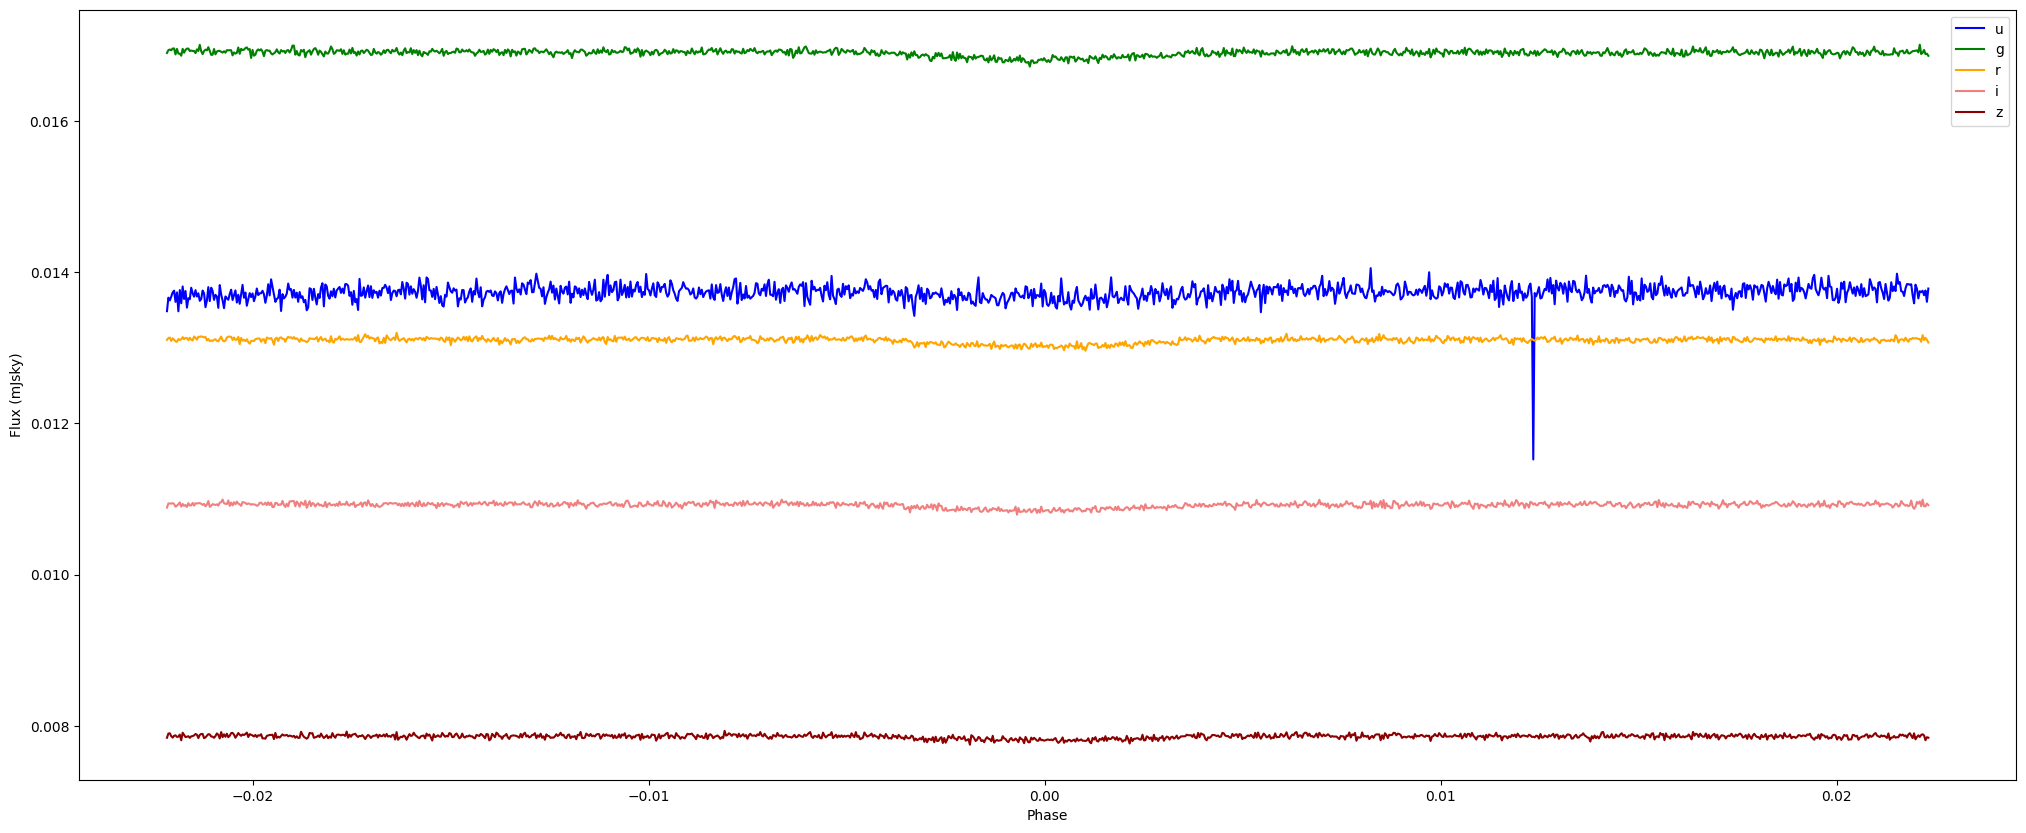

In [23]:
#plotting the flux calibrated lightcurves
bands = ['u', 'g', 'r', 'i', 'z']
colours = ['b', 'g', 'orange', 'lightcoral', 'darkred']

fig, ax = plt.subplots(figsize=(25, 10))

# Plot each band with its corresponding color and label
ax.plot(phase_u, cal_flux_u , color=colours[0], label=bands[0])
ax.plot(phase_u, cal_flux_g , color=colours[1], label=bands[1])
ax.plot(phase_u, cal_flux_r , color=colours[2], label=bands[2])
ax.plot(phase_u, cal_flux_i , color=colours[3], label=bands[3])
ax.plot(phase_u, cal_flux_z , color=colours[4], label=bands[4])



# Add labels and formatting
ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')

# Add a legend to distinguish the lines
ax.legend()

plt.show()

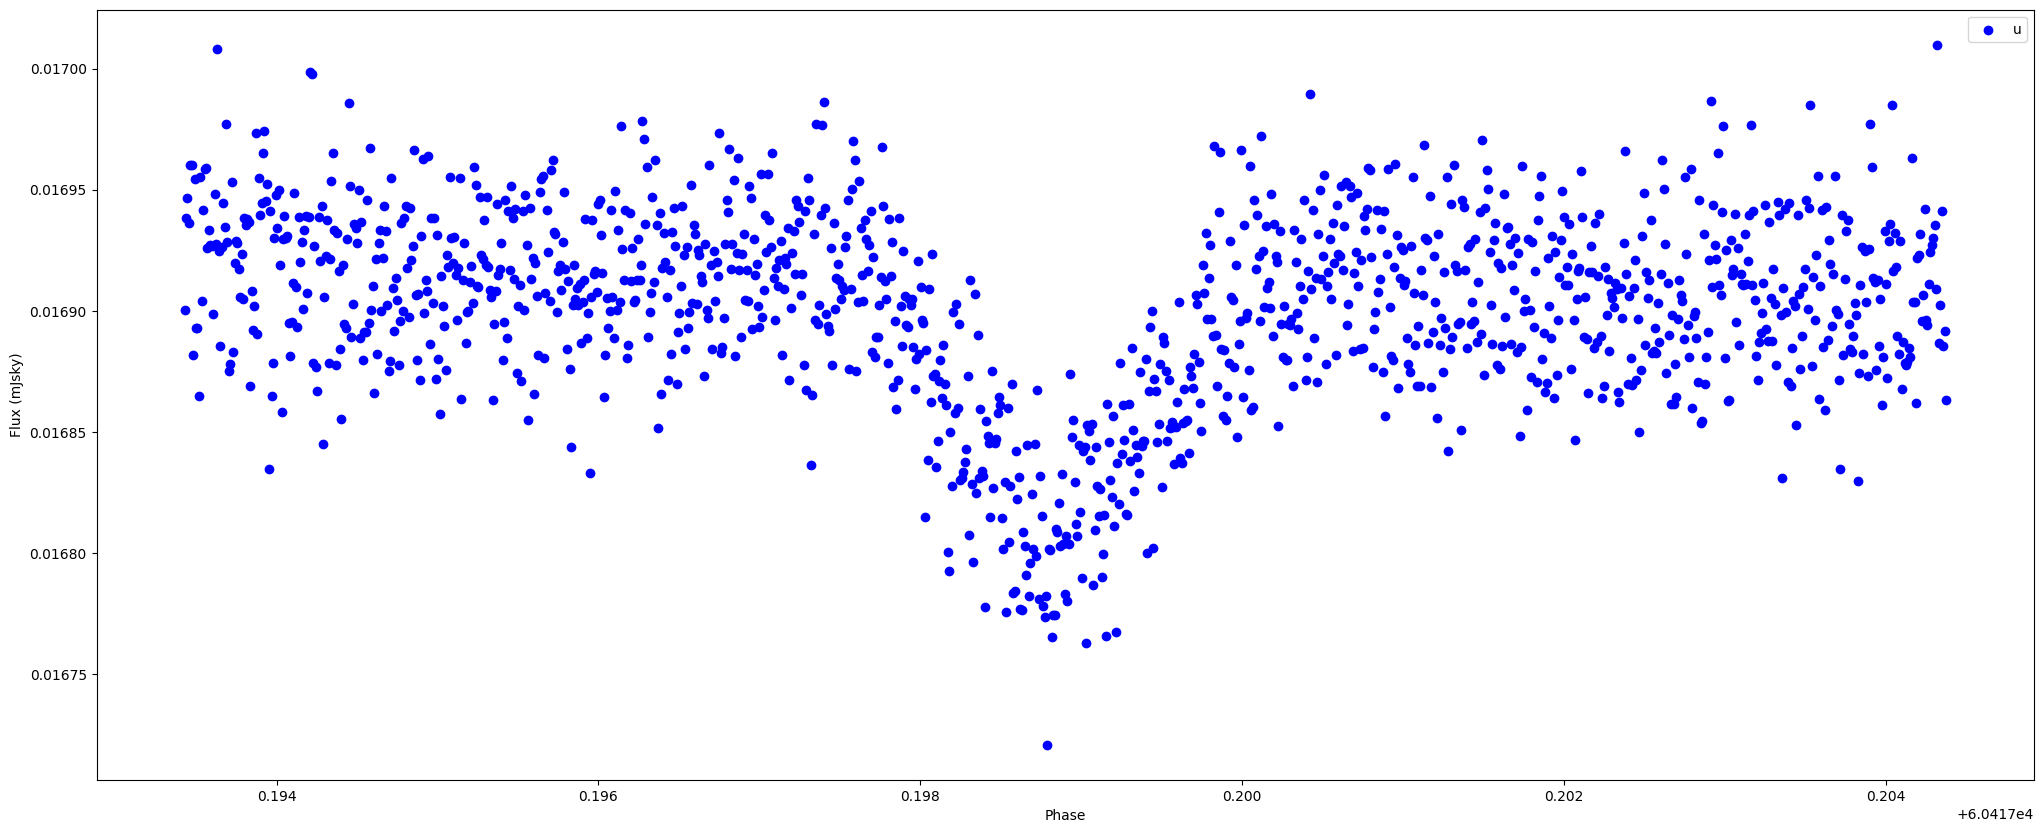

605
60417.1987910178


In [24]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(baryobs_u_t.value,cal_flux_g, color=colours[0], label=bands[0])


ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')

# Add a legend to distinguish the lines
ax.legend()

plt.show()
print(np.argmin(cal_flux_g))
print(baryobs_g_t[605])

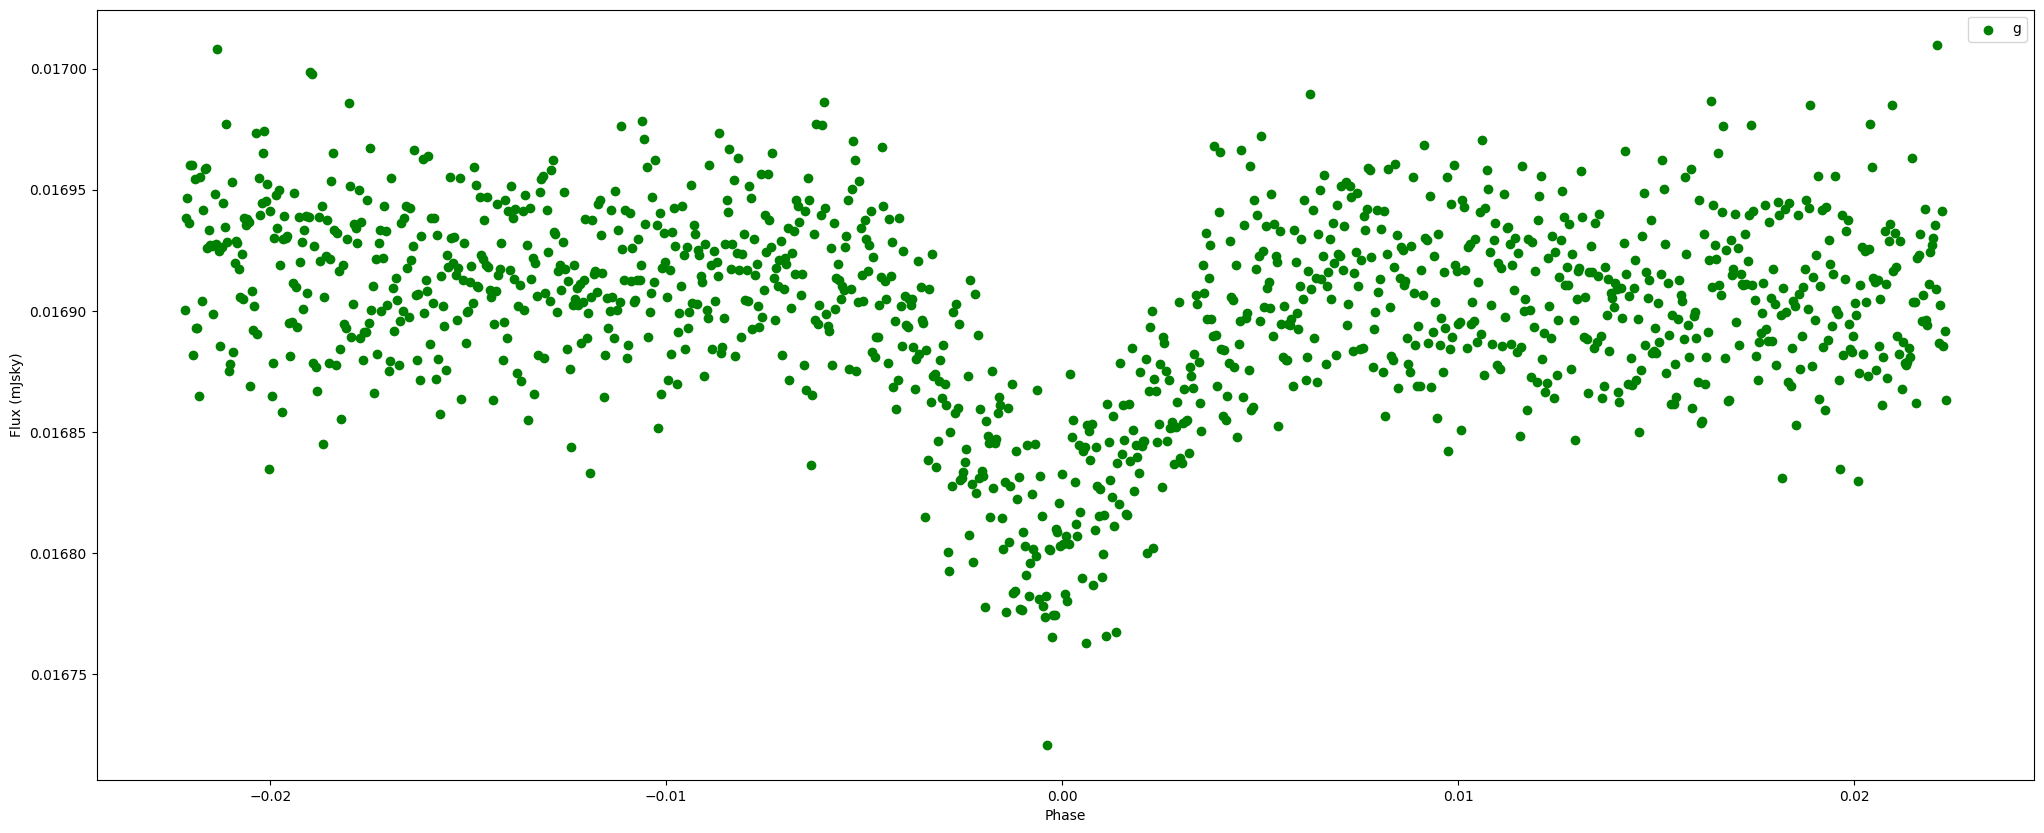

In [25]:



phase_g = calculate_phase(baryobs_g_t.value,reference_epoch,period)
fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(phase_g,cal_flux_g, color=colours[1], label=bands[1])

ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')

# Add a legend to distinguish the lines
ax.legend()


In [26]:
w_factors = np.repeat(1,len(obstime_u_t))



g_mid = np.array(sci_g.t)
g_te = np.array(sci_g.te)

r_mid = np.array(sci_r.t)
r_te = np.array(sci_r.te)

i_mid = np.array(sci_i.t)
i_te = np.array(sci_i.te)

z_mid = np.array(sci_z.t)
z_te = np.array(sci_z.te)

In [27]:
#going to column stack data for the eventual lcurve data file

#normal_g = (cal_flux_g - np.min(cal_flux_g)) / (np.max(cal_flux_g) - np.min(cal_flux_g))

sci_flux_u_err = np.array(diffFluxErr_u)
sci_flux_g_err = np.array(diffFluxErr_g)
sci_flux_r_err = np.array(diffFluxErr_r)
sci_flux_i_err = np.array(diffFluxErr_i)
sci_flux_z_err = np.array(diffFluxErr_z)




w_factors = np.array(w_factors)

col_u = np.column_stack((u_mid, u_te, cal_flux_u, sci_flux_u_err, w_factors, w_factors))
col_g = np.column_stack((g_mid, g_te, cal_flux_g, sci_flux_g_err, w_factors, w_factors))
col_r = np.column_stack((r_mid, r_te, cal_flux_r, sci_flux_r_err, w_factors, w_factors))
col_i = np.column_stack((i_mid, i_te, cal_flux_i, sci_flux_i_err, w_factors, w_factors))
col_z = np.column_stack((z_mid, z_te, cal_flux_z, sci_flux_z_err, w_factors, w_factors))




In [28]:
def eclipse_clip(x,y,z,a,b,upper,lower):
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    a = np.array(a)
    # Find the indices where x is within the specified range
    indices = (x >= lower) & (x <= upper)
    
    # Clip the x and y arrays using the indices
    x_clipped = x[indices]
    y_clipped = y[indices]
    z_clipped = z[indices]
    a_clipped = a[indices]
    b_clipped = b[indices]
    w_clip = np.ones_like(x_clipped)
    
    return x_clipped, y_clipped, z_clipped, a_clipped, w_clip, b_clipped
    
u_phase_clip , u_flux_clip, u_flux_err_clip , u_mid_clip,w_clip,u_te_clip = eclipse_clip(phase_u,cal_flux_u,sci_flux_u_err, u_mid,u_te, 0.025,-0.025)
g_phase_clip , g_flux_clip, g_flux_err_clip , g_mid_clip,w_clip,g_te_clip = eclipse_clip(phase_u,cal_flux_g,sci_flux_g_err, g_mid,g_te, 0.025,-0.025)
r_phase_clip , r_flux_clip, r_flux_err_clip , r_mid_clip,w_clip,r_te_clip = eclipse_clip(phase_u,cal_flux_r,sci_flux_r_err, r_mid,r_te, 0.025,-0.025)
i_phase_clip , i_flux_clip, i_flux_err_clip , i_mid_clip,w_clip,i_te_clip = eclipse_clip(phase_u,cal_flux_i,sci_flux_i_err, i_mid,i_te, 0.025,-0.025)
z_phase_clip , z_flux_clip, z_flux_err_clip , z_mid_clip,w_clip,z_te_clip = eclipse_clip(phase_u,cal_flux_z,sci_flux_z_err, z_mid,z_te, 0.025,-0.025)

In [29]:
def weighted_mean(y, y_err):
    weights = 1 / y_err**2
    return np.sum(y * weights) / np.sum(weights)

u_w_mean = weighted_mean(u_flux_clip,u_flux_err_clip)
g_w_mean = weighted_mean(g_flux_clip,g_flux_err_clip)
r_w_mean = weighted_mean(r_flux_clip,r_flux_err_clip)
i_w_mean = weighted_mean(i_flux_clip,i_flux_err_clip)
z_w_mean = weighted_mean(z_flux_clip,z_flux_err_clip)


print(u_flux_clip)
print(u_w_mean)
print(g_w_mean)
print(r_w_mean)
print(i_w_mean)
print(z_w_mean)
print(cal_flux_u)


[0.01348491 0.01366353 0.01362776 ... 0.01375812 0.01360903 0.01378412]
0.013728633891584146
0.016900332559235495
0.013099536514571035
0.010919259384474866
0.007857760760108233
[0.01348491 0.01366353 0.01362776 ... 0.01375812 0.01360903 0.01378412]


In [30]:
#rescale to the means from 0430 with stevens zeropoints
resc_u_0430 = 0.015106100908592811
resc_g_0430 = 0.017743889722111293
resc_r_0430 = 0.013882226190810303
resc_i_0430 = 0.011058254734357922
resc_z_0430 = 0.008153015257795495


u_flux_resc_clip = u_flux_clip + (resc_u_0430 - u_w_mean)
g_flux_resc_clip = g_flux_clip + (resc_g_0430 - g_w_mean)
r_flux_resc_clip = r_flux_clip + (resc_r_0430 - r_w_mean)
i_flux_resc_clip = i_flux_clip + (resc_i_0430 - i_w_mean)
z_flux_resc_clip = z_flux_clip + (resc_z_0430 - z_w_mean)

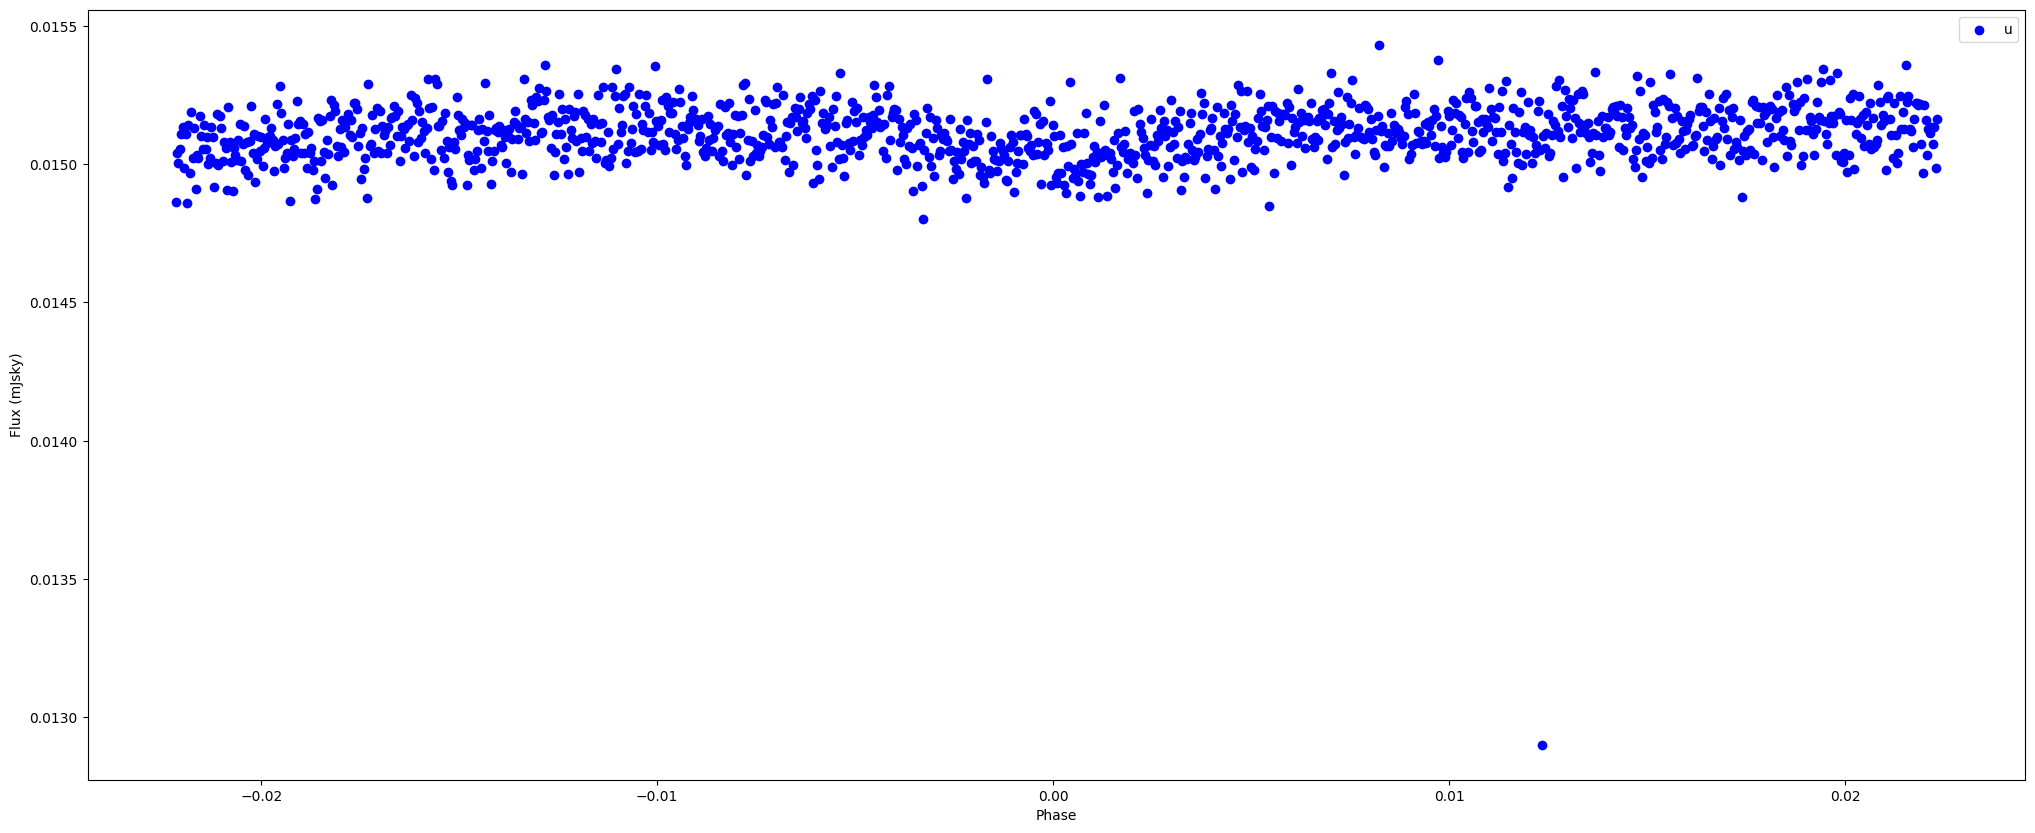

In [31]:
fig, ax = plt.subplots(figsize=(25, 10))

ax.scatter(u_phase_clip,u_flux_resc_clip, color=colours[0], label=bands[0])



ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')
#ax.set_ylim(1.30,1.55)
# Add a legend to distinguish the lines
ax.legend()

plt.show()

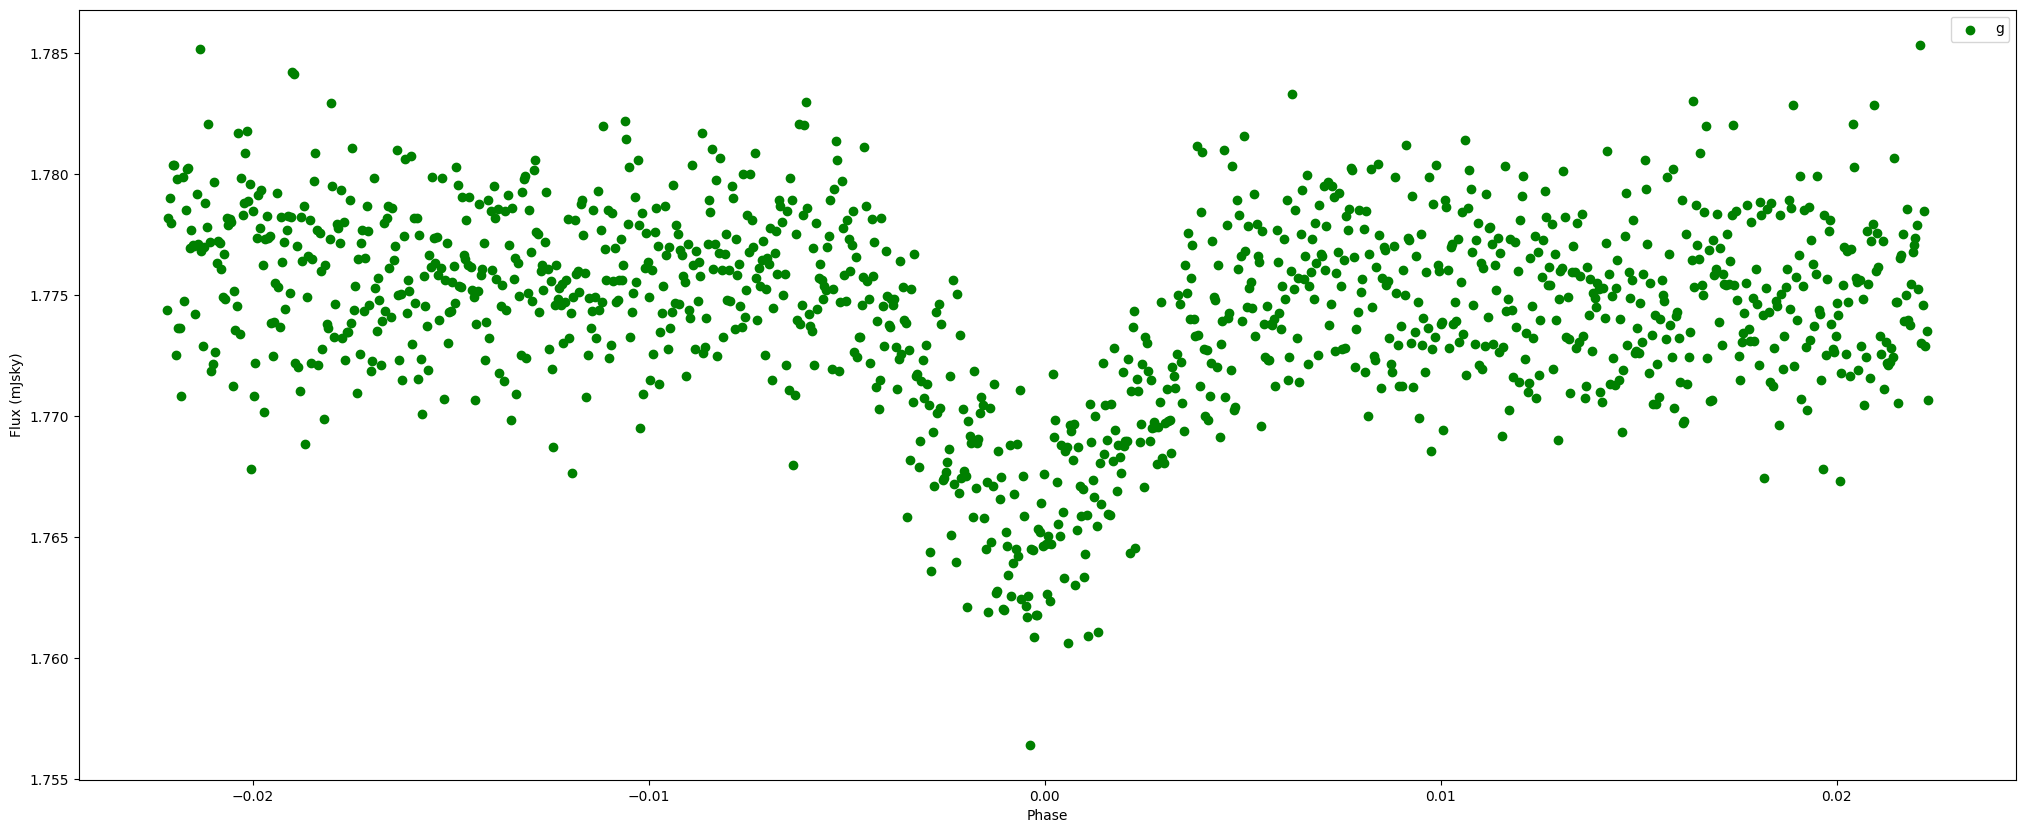

In [32]:
fig, ax = plt.subplots(figsize=(25, 10))

ax.scatter(g_phase_clip,g_flux_resc_clip*100, color=colours[1], label=bands[1])


ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')
#ax.set_ylim(1.55,1.80)

ax.legend()

plt.show()

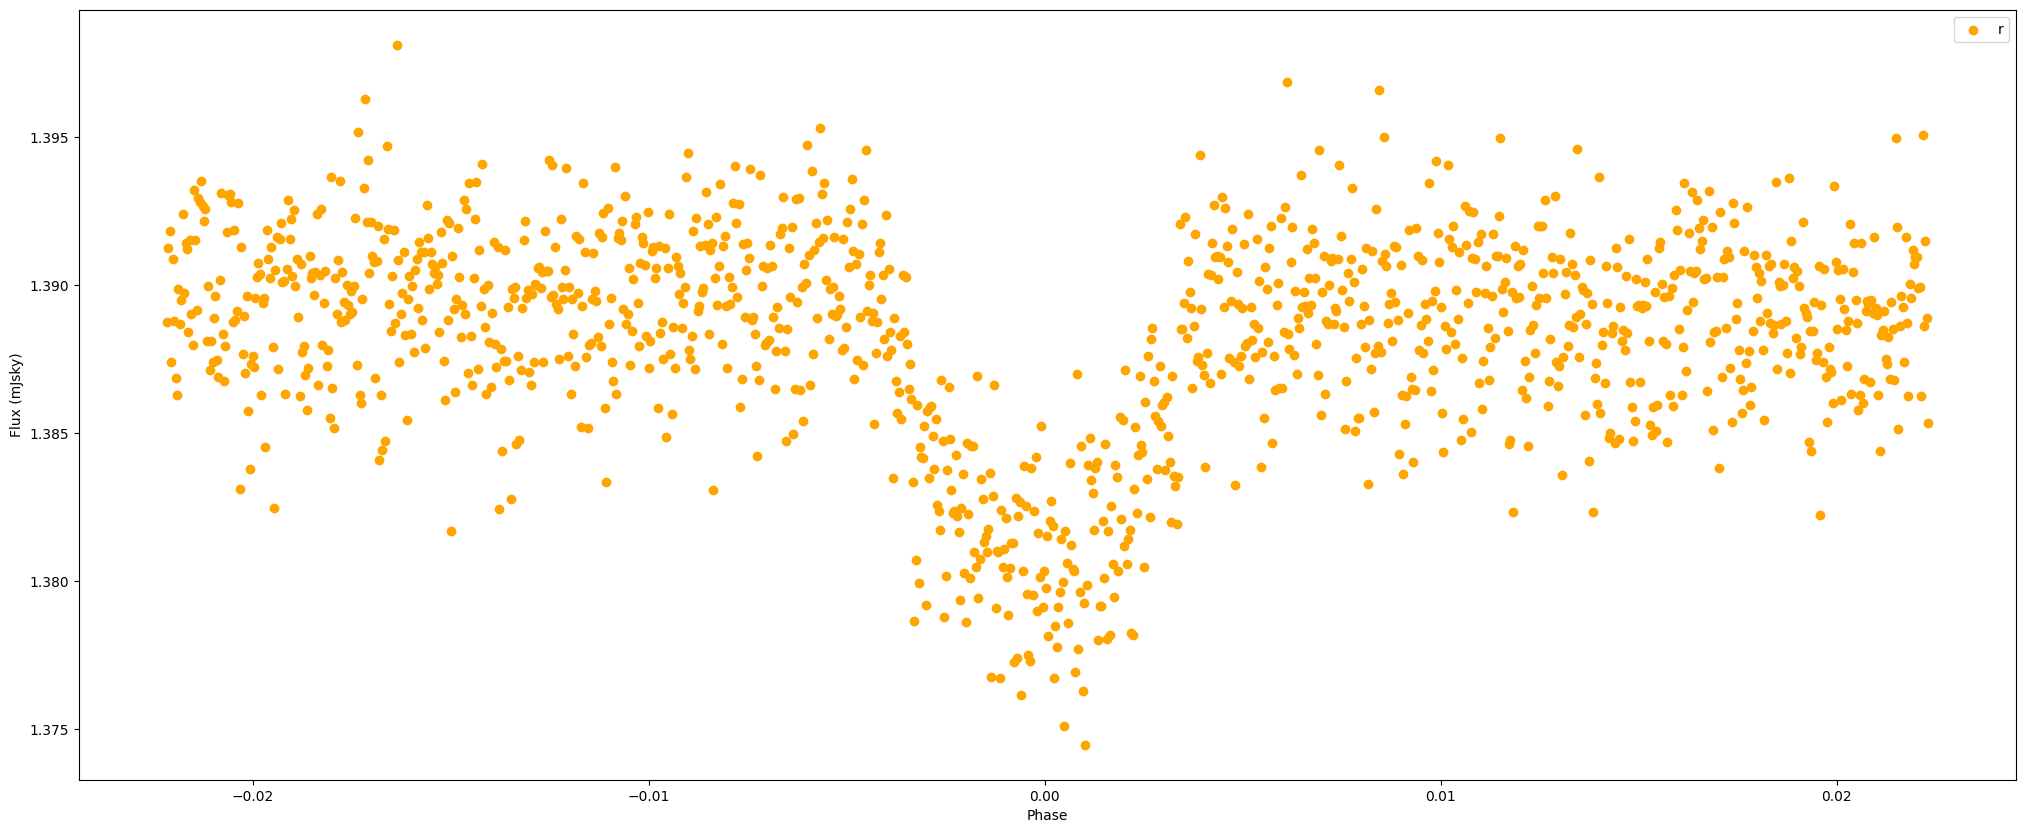

In [33]:
fig, ax = plt.subplots(figsize=(25, 10))

ax.scatter(r_phase_clip,r_flux_resc_clip*100, color=colours[2], label=bands[2])

ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')
#ax.set_ylim(1.20,1.35)

ax.legend()

plt.show()

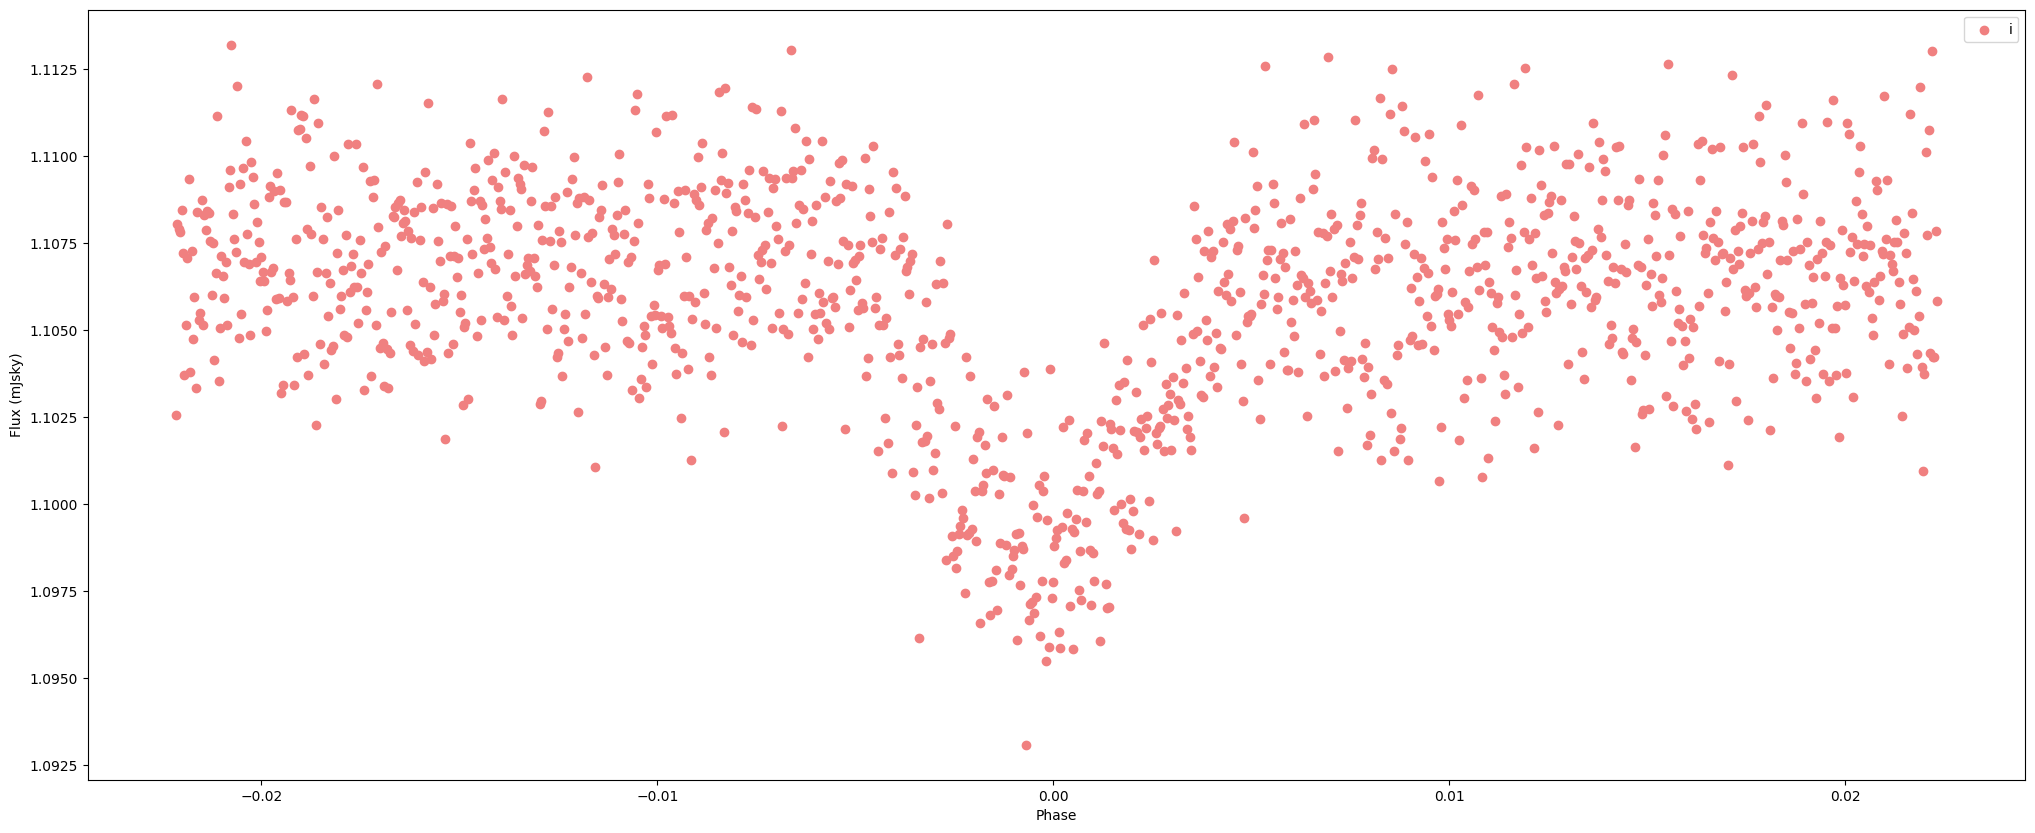

In [34]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(i_phase_clip,i_flux_resc_clip*100, color=colours[3], label=bands[3])


ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')
#ax.set_ylim(0.90,1.05)

ax.legend()

plt.show()

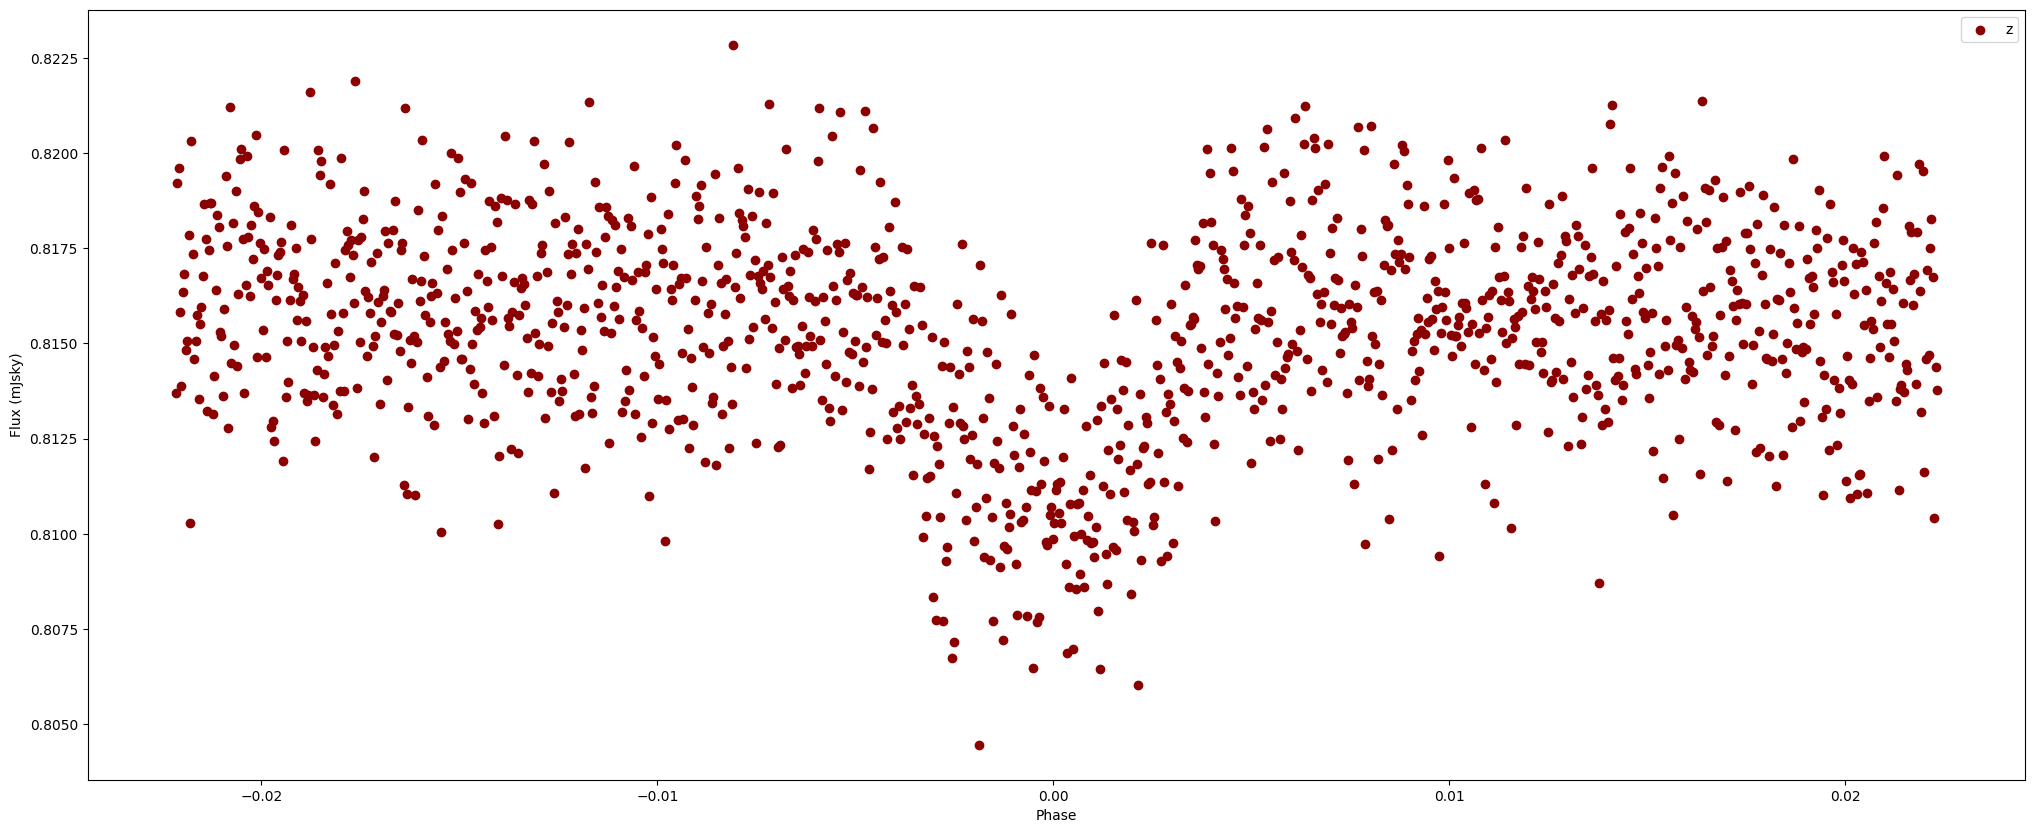

In [35]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(z_phase_clip,z_flux_resc_clip*100, color=colours[4], label=bands[4])


ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')
#ax.set_ylim(0.6,0.80)
# Add a legend to distinguish the lines
ax.legend()

plt.show()

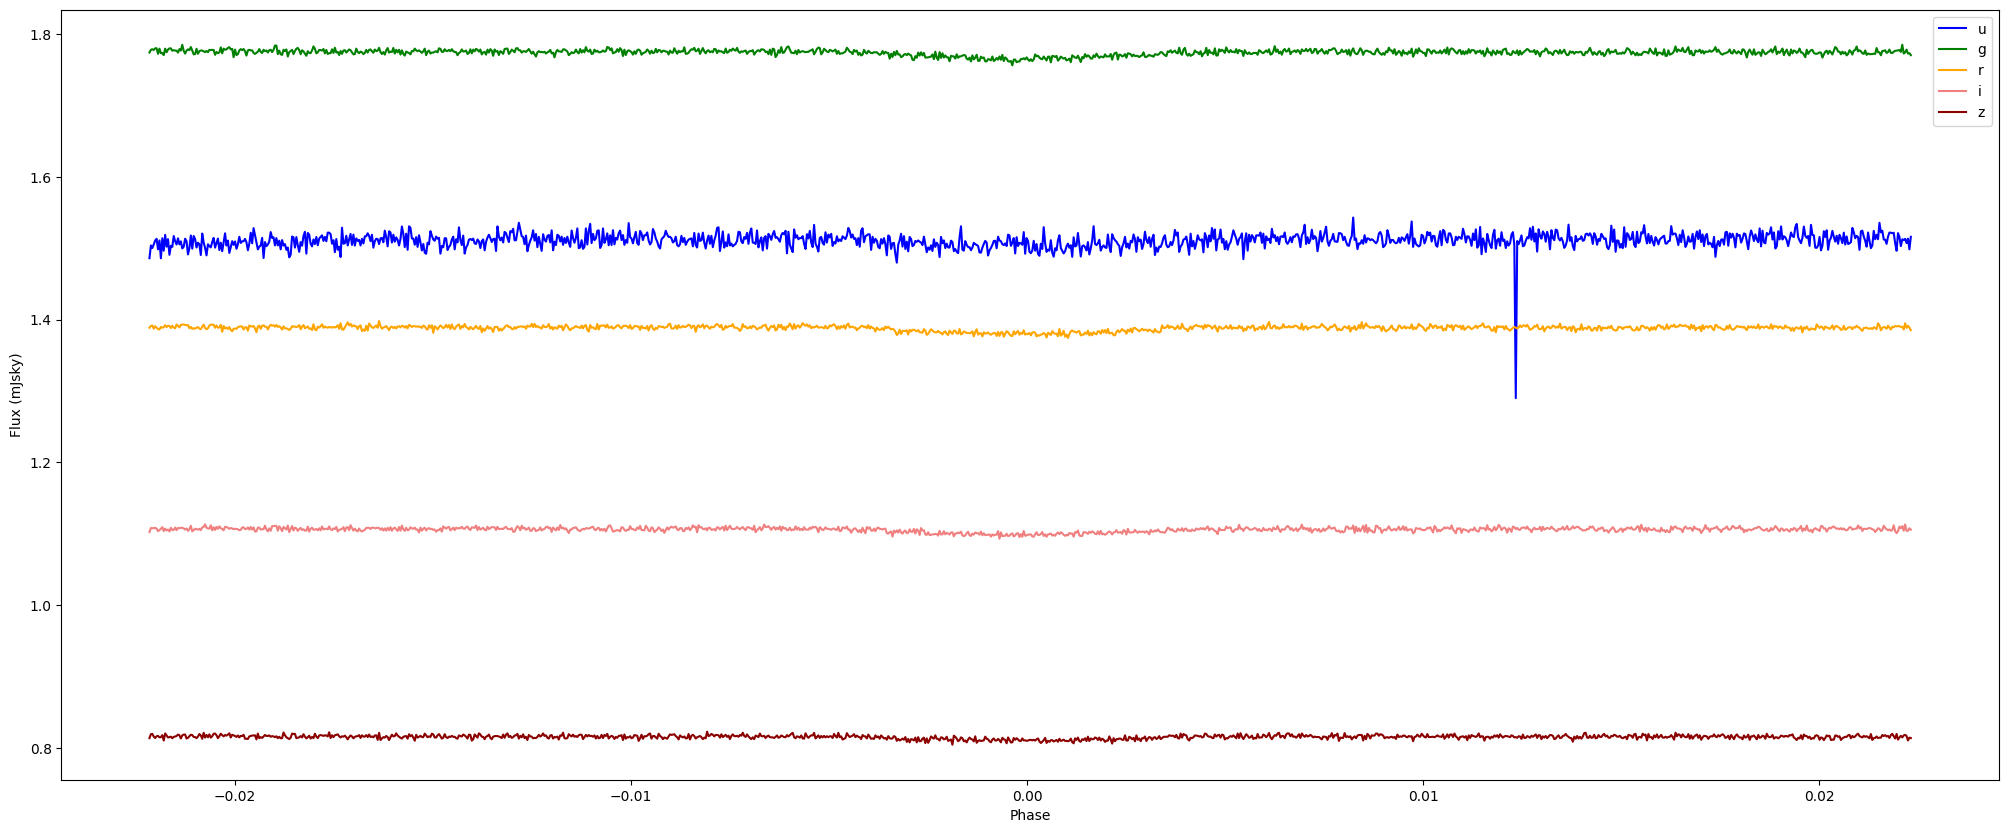

In [36]:
#plotting the flux calibrated lightcurves
bands = ['u', 'g', 'r', 'i', 'z']
colours = ['b', 'g', 'orange', 'lightcoral', 'darkred']

fig, ax = plt.subplots(figsize=(25, 10))

# Plot each band with its corresponding color and label
ax.plot(u_phase_clip,u_flux_resc_clip*100, color=colours[0], label=bands[0])
ax.plot(u_phase_clip, g_flux_resc_clip * 100, color=colours[1], label=bands[1])
ax.plot(u_phase_clip, r_flux_resc_clip * 100, color=colours[2], label=bands[2])
ax.plot(u_phase_clip, i_flux_resc_clip * 100, color=colours[3], label=bands[3])
ax.plot(u_phase_clip, z_flux_resc_clip * 100, color=colours[4], label=bands[4])



# Add labels and formatting
ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')

# Add a legend to distinguish the lines
ax.legend()

plt.show()

In [37]:
#going to column stack data for the eventual lcurve data file

#normal_g = (cal_flux_g - np.min(cal_flux_g)) / (np.max(cal_flux_g) - np.min(cal_flux_g))

sci_flux_u_err = np.array(diffFluxErr_u)
sci_flux_g_err = np.array(diffFluxErr_g)
sci_flux_r_err = np.array(diffFluxErr_r)
sci_flux_i_err = np.array(diffFluxErr_i)
sci_flux_z_err = np.array(diffFluxErr_z)



#cal_flux_u = np.array(ratio_u)
#cal_flux_g = np.array(ratio_g)
#cal_flux_r = np.array(ratio_r)
#cal_flux_i = np.array(ratio_i)
#cal_flux_z = np.array(ratio_z)

w_factors = np.array(w_factors)

#col_u = np.column_stack((u_mid, u_te, cal_flux_u, sci_flux_u_err, w_factors, w_factors))
#col_g = np.column_stack((g_mid, g_te, cal_flux_g, sci_flux_g_err, w_factors, w_factors))
#col_r = np.column_stack((r_mid, r_te, cal_flux_r, sci_flux_r_err, w_factors, w_factors))
#col_i = np.column_stack((i_mid, i_te, cal_flux_i, sci_flux_i_err, w_factors, w_factors))
#col_z = np.column_stack((z_mid, z_te, cal_flux_z, sci_flux_z_err, w_factors, w_factors))




np.savetxt(r'/home/pha19jgb/LCURVE/18.11_Testing/2024_04_16/U/u_norm.txt',col_u)
np.savetxt(r'/home/pha19jgb/LCURVE/2024_04_16/G/g_norm.txt',col_g)
np.savetxt(r'/home/pha19jgb/LCURVE/2024_04_16/R/r_norm.txt',col_r)
np.savetxt(r'/home/pha19jgb/LCURVE/2024_04_16/I/i_norm.txt',col_i)
np.savetxt(r'/home/pha19jgb/LCURVE/2024_04_16/Z/z_norm.txt',col_z)


In [38]:
#u_tO = 60431.227660469
g_tO = 60417.19773877952 
r_tO =  60417.197760000039
i_tO = 60417.197763553188 
z_tO = 60417.197738960371 

#u_err =0.000088457279
g_err =1.9937525e-05
r_err =1.6764832e-05
i_err =2.0790109e-05 
z_err =2.8564202e-05


#u_w = 1/u_err**2
g_w =  1/g_err**2
r_w =  1/r_err**2
i_w =  1/i_err**2
z_w = 1/z_err**2



invmean = ((g_tO * g_w) + (r_tO * r_w) + (i_tO * i_w) + (z_tO * z_w)) /( g_w +r_w + i_w + z_w )
invmean_err = np.sqrt(1 / ( g_w +r_w + i_w + z_w ))
cycle_number = (invmean - reference_epoch) / period

In [39]:
print(invmean)
print(invmean_err)
print(cycle_number)

60417.197752619264
1.0199374460632695e-05
19402.995408699077


In [40]:
col_u_clip = np.column_stack((u_mid_clip, u_te_clip, u_flux_clip, u_flux_err_clip, w_clip, w_clip))
col_g_clip = np.column_stack((g_mid_clip, g_te_clip, g_flux_clip, g_flux_err_clip, w_clip, w_clip))
col_r_clip = np.column_stack((r_mid_clip, r_te_clip, r_flux_clip, r_flux_err_clip, w_clip, w_clip))
col_i_clip = np.column_stack((i_mid_clip, i_te_clip, i_flux_clip, i_flux_err_clip, w_clip, w_clip))
col_z_clip = np.column_stack((z_mid_clip, z_te_clip, z_flux_clip, z_flux_err_clip, w_clip, w_clip))

np.savetxt(r'/home/pha19jgb/udat0416.txt',col_u_clip)
np.savetxt(r'/home/pha19jgb/gdat0416.txt',col_g_clip)
np.savetxt(r'/home/pha19jgb/rdat0416.txt',col_r_clip)
np.savetxt(r'/home/pha19jgb/idat0416.txt',col_i_clip)
np.savetxt(r'/home/pha19jgb/zdat0416.txt',col_z_clip)

In [41]:
#u_te to new "Phase" units
u_te_ph = u_te_clip / period
g_te_ph = g_te_clip / period
r_te_ph = r_te_clip / period
i_te_ph = i_te_clip / period
z_te_ph = z_te_clip / period
print(u_te_ph)

[3.564602e-05 3.564602e-05 3.564602e-05 ... 3.564602e-05 3.564602e-05
 3.564602e-05]


In [42]:
print(np.argmin(u_flux_resc_clip))
u_phase_clip = np.delete(u_phase_clip,958)
u_mid_clip = np.delete(u_mid_clip,958)
u_te_ph = np.delete(u_te_ph,958)
u_flux_resc_clip = np.delete(u_flux_resc_clip,958)
u_flux_err_clip = np.delete(u_flux_err_clip,958)
w_clip1 = np.delete(w_clip,958)

958


In [43]:
ph_col_u_clip = np.column_stack((u_phase_clip, u_te_ph, u_flux_resc_clip, u_flux_err_clip, w_clip1, w_clip1))
new_g = np.column_stack((g_phase_clip,g_mid_clip,g_flux_resc_clip,g_flux_err_clip))
ph_col_g_clip = np.column_stack((g_phase_clip, g_te_ph, g_flux_resc_clip, g_flux_err_clip, w_clip, w_clip))
ph_col_r_clip = np.column_stack((r_phase_clip, r_te_ph, r_flux_resc_clip, r_flux_err_clip, w_clip, w_clip))
ph_col_i_clip = np.column_stack((i_phase_clip, i_te_ph, i_flux_resc_clip, i_flux_err_clip, w_clip, w_clip))
ph_col_z_clip = np.column_stack((z_phase_clip, z_te_ph, z_flux_resc_clip, z_flux_err_clip, w_clip, w_clip))

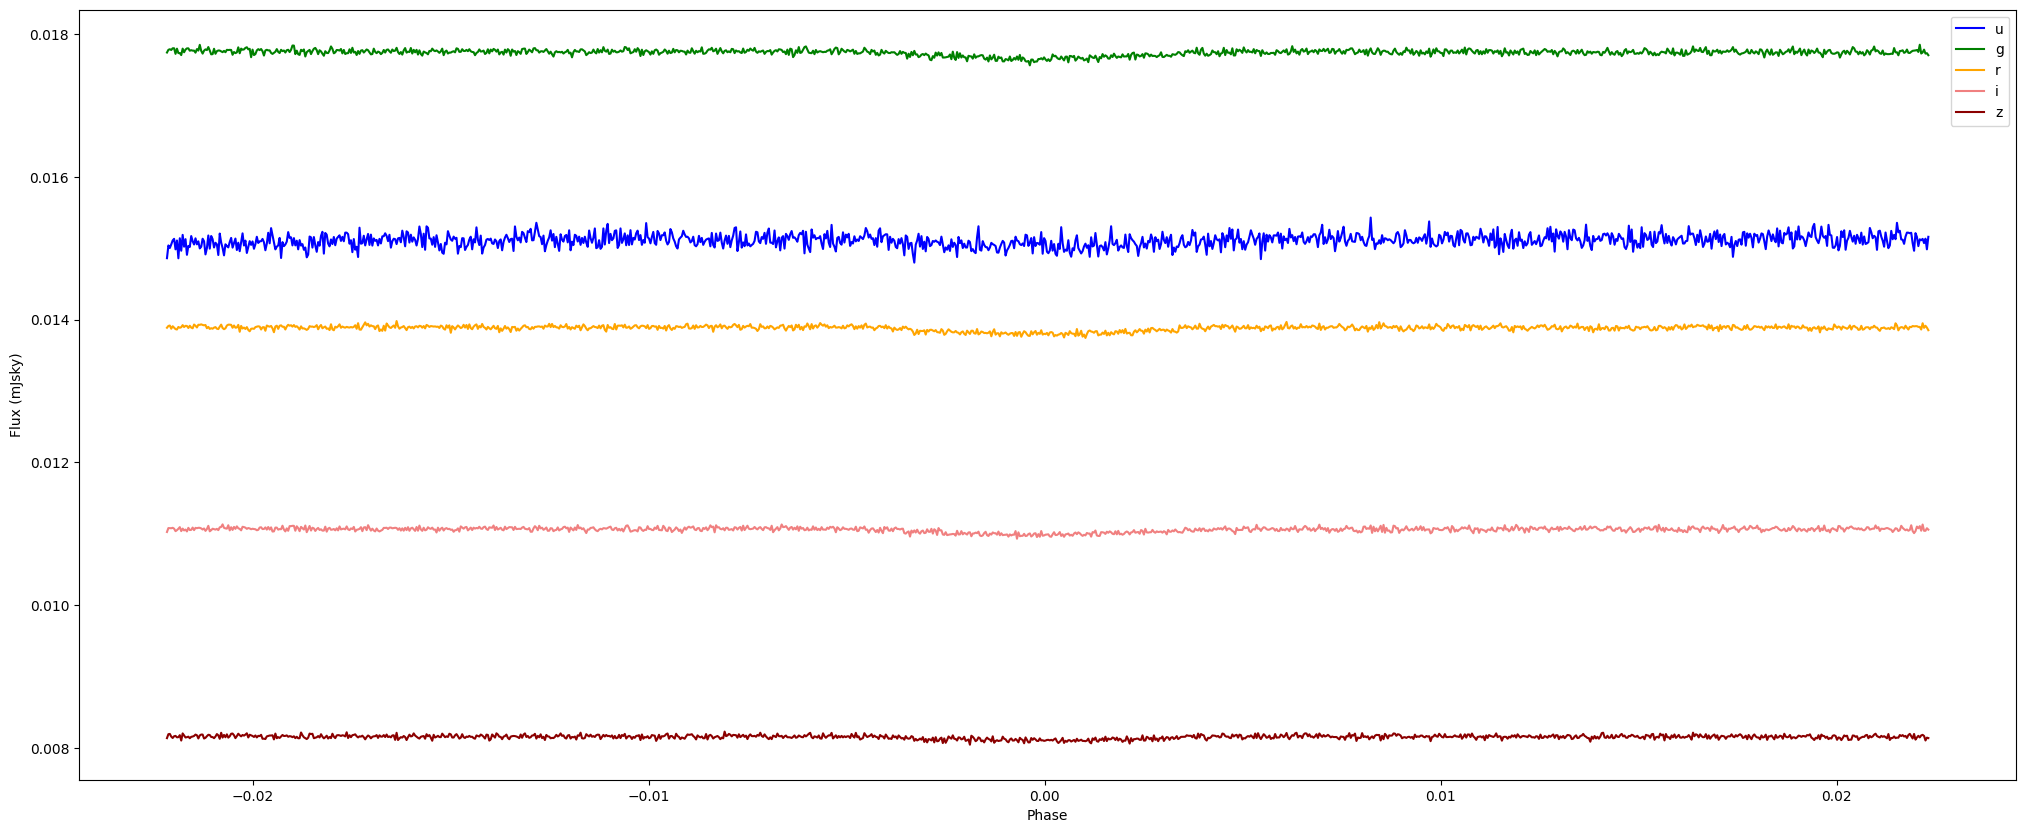

In [44]:
#plotting the flux calibrated lightcurves
bands = ['u', 'g', 'r', 'i', 'z']
colours = ['b', 'g', 'orange', 'lightcoral', 'darkred']

fig, ax = plt.subplots(figsize=(25, 10))

# Plot each band with its corresponding color and label
ax.plot(u_phase_clip,u_flux_resc_clip, color=colours[0], label=bands[0])
ax.plot(g_phase_clip, g_flux_resc_clip , color=colours[1], label=bands[1])
ax.plot(r_phase_clip, r_flux_resc_clip , color=colours[2], label=bands[2])
ax.plot(i_phase_clip, i_flux_resc_clip , color=colours[3], label=bands[3])
ax.plot(z_phase_clip, z_flux_resc_clip , color=colours[4], label=bands[4])



# Add labels and formatting
ax.set_xlabel('Phase')
ax.set_ylabel('Flux (mJsky)')

# Add a legend to distinguish the lines
ax.legend()

plt.show()

In [45]:
np.savetxt(r'/home/pha19jgb/g_bin.txt',new_g)

np.savetxt(r'/home/pha19jgb/LCURVE/ph_udat0416.txt',ph_col_u_clip)
np.savetxt(r'/home/pha19jgb/ph_gdat0416.txt',ph_col_g_clip)
np.savetxt(r'/home/pha19jgb/ph_rdat0416.txt',ph_col_r_clip)
np.savetxt(r'/home/pha19jgb/ph_idat0416.txt',ph_col_i_clip)
np.savetxt(r'/home/pha19jgb/ph_zdat0416.txt',ph_col_z_clip)